# Analyzing Investment Management Industry Firms 

If you're not familiar with the alternative assets space, it is generally known as being secretive and close lipped. 

Focus here was less on traditional asset managers (mutual funds) and more on hedge funds, private equity funds, and other institutional alternative asset managers. 

Intuition is that roles and culture are different at a Blackrock (4K reviews, 40K employees) and at Blackstone (500 reviews, 1000 employees) although both are considered behemoths in their respective spaces. 

Several of the largest names in the space have very few glassdoor reviews, ie: Tiger Global Viking Global Farallon HPS Partners 

Company sizes are smaller 

Full list here https://www.peregrinecommunications.com/hubfs/Reports/Alts-50-Report-2021-Peregrine-Communications.pdf

In [208]:
import pandas as pd
import numpy as np
import requests
import time
import math
import re
import pickle
import itertools
import glob
import string

import contractions

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.collocations import *

from gsdmm import MovieGroupProcess

from textblob import TextBlob

import gensim 
import gensim.downloader as gensim_api
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

# from tensorflow.keras import models, layers, preprocessing as kprocessing

from keras_preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pyLDAvis import gensim_models
import pyLDAvis

import warnings
warnings.filterwarnings('ignore')

In [18]:
sns.set_style('darkgrid')
sns.set_palette("winter_r")

## Data
* Glassdoor Reviews: Top Alternative Asset Managers 
* Reviews were scraped using this tool: LINK TODO 

### Analysis
* What are the top companies doing really well? 
* From an employee standpoint, why are these the top companies? What matters to employees the most? 
* What are the companies performing poorly doing wrong? From an employee standpoint, why are these companies failing? 
* Are different types of employees feeling more or less valued? (analyze by position) 
* Topic Modeling 

## Load Files 

In [79]:
"""
Takes in a list of csv files using glob 
Output: dataframe combining all csvs vertically (axis=0)
Assumes all csvs have same column names 
"""
def files_to_df(glob_csv):
    final_df = pd.DataFrame()
    
    for file in glob_csv:
        company_name = file.split('\\')[1].split('.')[0] # get the company name from the file 
        try:
            df = pd.read_csv(file)
        except:
            df = pd.read_csv(file, encoding='latin1')
        
        # drop the extra index column 
        df = df.drop(df.columns[0], axis=1)
        
        #check if there's a company column, if not, add company name to all rows  
        if pd.isnull(df.iloc[0].company):
            df.company = company_name
        
        final_df = pd.concat([final_df, df])
        
    return final_df

In [80]:
""" 
Load all csv files from folders 
drop each group into a dataframe 

"""
csvfiles = glob.glob('reviews/investment/' + '*.csv')
investment_reviews_raw =  files_to_df(csvfiles)

In [81]:
print(investment_reviews_raw.isna().sum())
print(len(investment_reviews_raw))

company              0
headline            20
date                 0
overall_rating       0
author_position    920
pros                 0
cons                 0
dtype: int64
8512


In [82]:
investment_reviews_raw.company.unique()

array(['Acadian', 'Advent', 'American Capital', 'Angelo Gordon',
       'Apollo Global Management', 'AQR Capital Management',
       'Ares Management', 'Bain Capital', 'Balyasny Asset Management',
       'Bayview Asset Management', 'Bessemer Trust Company',
       'Boston Private', 'Bridgewater', 'Brookfield Asset Management',
       'Cerberus', 'Citadel', 'CPP Investments', 'CVC', 'DE Shaw',
       'Fortress Investment Group', 'Geller & Company',
       'HarbourVest Partners, LLC', 'Intellectual Ventures',
       'Jane Street', 'Janus Capital', 'Jump Trading', 'KKR',
       'Lord Abbett & Co.', 'Man Group', 'Millennium', 'Moelis & Company',
       'Neuberger Berman', 'Neuberger', 'Oaktree Capital Management',
       'Oppenheimer Holdings', 'PIMCO', 'PineBridge Investments',
       'Point72', 'Putnam Investments', 'Sculptor Capital', 'Sequoia',
       'Silver Lake', 'SoftBank', 'Techstars', 'The Blackstone Group',
       'The Carlyle Group', 'TPG', 'Two Sigma', 'Warburg Pincus'],
     

In [83]:
investment_reviews_raw

company                                           headline  \
0          Acadian                                    work experience   
1          Acadian                    A Case Study in Poor Leadership   
2          Acadian                                  Overall very good   
3          Acadian         Great firm,  nice to be back in the office   
4          Acadian  Good work life balance. Opportunities to contr...   
..             ...                                                ...   
55  Warburg Pincus                                      Great Company   
56  Warburg Pincus                           Overall Great Experience   
57  Warburg Pincus                                   Winter Associate   
58  Warburg Pincus                Wonderful group of talented people.   
59  Warburg Pincus                                           10 years   

          date  overall_rating          author_position  \
0   2022-03-13             3.0        Trading Developer   
1   2022-03-10             1.0       Anonymous Employee   
2   2022-03-10             4.0       Anonymous Employee   
3   2022-03-02             5.0       Anonymous Employee   
4   2022-02-17             5.0  Investment Data Analyst   
..         ...             ...                      ...   
55  2015-05-07             5.0         Network Engineer   
56  2015-05-06             4.0                      NaN   
57  2015-02-02             5.0                      NaN   
58  2014-09-04             5.0                      NaN   
59  2014-04-20             3.0       Anonymous Employee   

                                                 pros  \
0    good small team management and agile environment   
1   There is no shortage of work at Acadian, you w...   
2             Great benefits and a lot of good people   
3   Great firm, nice comp package (health and educ...   
4   Environment is relaxed. Will have time to comp...   
..                                                ...   
55  Great Company, great benefits, great people in...   
56        Great Benefits. Great People. Great Office.   
57  Amazing team to work with. But the workload is...   
58  time-off policies, personal growth, free lunch...   
59  leading PE firm\r\nlong history of investment ...   

                                                 cons  
0   Excessive team fragmentation recently caused e...  
1   Acadian’s culture was very disappointing. For ...  
2                            Nothing much to speak of  
3   Took a while to get back to the office after C...  
4   Satellite office so coordination with HQ in Bo...  
..                                                ...  
55                          None that I can think of.  
56  Lately, the office has been going thru some ch...  
57  The workload is overwhelming. Hard to balance ...  
58  office culture, promotions, management, traini...  
59  people\r\nantiquated view of women, none in se...  

[8512 rows x 7 columns]

# I. EDA 

* Who are the top firms? 
* Are there similarities between these companies and the GD top companies? 
* For the companies that are not doing well, what are the reasons? 
* Are different types of employees feeling more or less valued? (analyze by position) 
* Which companies are on an upward trend? 
* Can we predict the rating based on the review? 

## Prep Data

### Define Methods

In [84]:
def position_level(position):
    executive_pattern = re.compile("[Cc]\w[Oo]")
    sr_manager_pattern = re.compile("(senior)\s(\w*)\s(manager)")
    if executive_pattern.match(position.lower()) or sr_manager_pattern.match(position.lower()):
        return "senior"
    
    senior = ["director", "chief", "executive", "senior manager", "head", "general manager", "leader", "president", "vp"]
    for pos in senior:
        if pos in position.lower():
            return "senior"
    
    return "other"


def position_department(position):
    try: 
        marketing_sales = ["marketing", "sales", "account manager","business development", "investor relations", "IR", "client",'customer']
        for pos in marketing_sales:
            if pos in position.lower():
                return "marketing_sales"

        hr = ["human", "hr", "recruit", "talent", "l&d", "learning", "people", "culture", "diversity", "inclusion"]
        for pos in hr:
            if pos in position.lower():
                return "hr_admin_legal"

        finance = ["accounting", 'operations', "valuation", "controller", "accountant", "finance", "payable", "receivable", "financial", "financial analyst", "fp"]
        for pos in finance:
            if pos in position.lower():
                return "accounting_finance_ops"

        tech = ["engineer", "data", "software", "ux", "ui", "experience", "developer", "product", "tech", "programmer", "it ", "information", "solution"]
        for pos in tech:
            if pos in position.lower():
                return "technology"
        
        investment = ["investment", "risk", "quantitative", "quant", "analyst", "trading", "trader", "investor", "front office", "portfolio", "pm"]
        for pos in investment:
            if pos in position.lower():
                return "investment"
        
        admin = ['assistant', 'administrative','receptionist', 'front desk','facilities']
        for pos in admin:
            if pos in position.lower():
                return "hr_admin_legal"
            
        legal = ['legal', 'attorney','legal', 'compliance']
        for pos in legal:
            if pos in position.lower():
                return "hr_admin_legal"
            
        intern = ['intern','student','summer']
        for pos in intern:
            if pos in position.lower():
                return "intern"
            
    except:
        print(position)
    
    return "other"

def fill_missing_values(df):
    position_missing = df.author_position.isna().sum()
    headline_missing = df.headline.isna().sum()
    print(df.isna().sum())
#     print(f"There are {position_missing} missing position records.")
#     print(f"There are {headline_missing} missing headline records.")
    
    df.author_position = df.author_position.fillna("unknown")
    df.headline = df.headline.fillna('')
    df.pros = df.pros.fillna('')
#     print('After filling missing values: ')
#     print(df.isna().sum())

    return df 

# 
def create_position_cols(df):
    df['position_department'] = df.author_position.apply(lambda x: position_department(x))
    df['position_level'] = df.author_position.apply(lambda x: position_level(x))
    return df 

# convert date column to datetime 
def convert_datetime(df):
    df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
    return df

# Add mean rating column 
def add_mean_rating(df):
    reviews_by_rating = df.groupby('company').overall_rating.mean().reset_index().rename(columns={'overall_rating':'mean_rating'})
    rating_dict = reviews_by_rating.set_index('company').to_dict()['mean_rating']
    df['mean_rating'] = df.company.apply(lambda x: float(rating_dict[x]))
    return df

# add review count column 
def add_review_count(df):
    reviews_count = df.groupby('company').headline.count().reset_index().rename(columns={'headline':'count'})
    count_dict = reviews_count.set_index('company').to_dict()['count']
    df['review_count'] = df.company.apply(lambda x: int(count_dict[x]))
    return df

# requires review_count column 
def remove_reviews(df, count=50):
    if 'review_count' not in df.columns:
        print('No review count column.')
        return df
    else:
        company_count = df.groupby('company').review_count.mean().reset_index()
        print(f'\nRemoving following companies with less than {count} reviews:')
        print(list(company_count[company_count.review_count < count].company))
        return df[df.review_count >= count]
    

In [85]:
# Cleaning and new columns 
reviews = convert_datetime(investment_reviews_raw)
reviews = reviews[reviews.date > '2011-12-31']  # only reviews in the past 10 years 
reviews = fill_missing_values(reviews)
reviews = create_position_cols(reviews) # create column for author position 

# print(f'There are {len(reviews[reviews.pros.apply(lambda x: pd.isnull(x))])} reviews with no text in the pros column.')
reviews = add_mean_rating(reviews)
reviews = add_review_count(reviews) 

company              0
headline            20
date                 0
overall_rating       0
author_position    861
pros                 0
cons                 0
dtype: int64


In [86]:
print(len(reviews))

8422


In [87]:
reviews.head()

company                                           headline       date  \
0  Acadian                                    work experience 2022-03-13   
1  Acadian                    A Case Study in Poor Leadership 2022-03-10   
2  Acadian                                  Overall very good 2022-03-10   
3  Acadian         Great firm,  nice to be back in the office 2022-03-02   
4  Acadian  Good work life balance. Opportunities to contr... 2022-02-17   

   overall_rating          author_position  \
0             3.0        Trading Developer   
1             1.0       Anonymous Employee   
2             4.0       Anonymous Employee   
3             5.0       Anonymous Employee   
4             5.0  Investment Data Analyst   

                                                pros  \
0   good small team management and agile environment   
1  There is no shortage of work at Acadian, you w...   
2            Great benefits and a lot of good people   
3  Great firm, nice comp package (health and educ...   
4  Environment is relaxed. Will have time to comp...   

                                                cons position_department  \
0  Excessive team fragmentation recently caused e...          technology   
1  Acadian’s culture was very disappointing. For ...               other   
2                           Nothing much to speak of               other   
3  Took a while to get back to the office after C...               other   
4  Satellite office so coordination with HQ in Bo...          technology   

  position_level  mean_rating  review_count  
0          other          3.9            50  
1          other          3.9            50  
2          other          3.9            50  
3          other          3.9            50  
4          other          3.9            50

## Overall review time trends

In [88]:
"""
visualize distribution of reviews by year.
input requires a 'date' and a headline column in datetime format
plots barplot 
"""

def reviews_by_year(df, display=True):
    temp_df = df.copy()
    temp_df['year'] = temp_df.date.apply(lambda x: x.year)
    count_year = temp_df.groupby('year').company.count().reset_index()
    count_year['count_normalized'] = round(((count_year['company'] / count_year['company'].sum()) * 100),2)
    plt.figure(figsize=(12,6))
    sns.barplot(x = count_year.year, y=count_year.company, palette='winter')
    plt.ylabel('Number of Reviews')
    plt.xlabel('Year')
    plt.show()
    if display:
        print(count_year[['year','count_normalized']])

def reviews_by_month(df, display=True):
    temp_df = df.copy()
    temp_df['month'] = temp_df.date.apply(lambda x: x.month)
    count_month = temp_df.groupby('month').company.count().reset_index()
    count_month['count_normalized'] = round(((count_month['company'] / count_month['company'].sum()) * 100),2)
    plt.figure(figsize=(12,6))
    sns.barplot(x = count_month.month, y=count_month.company, palette='winter')
    plt.ylabel('Number of Reviews')
    plt.xlabel('Month')
    plt.show()
    if display:
        print(count_month[['month','count_normalized']])

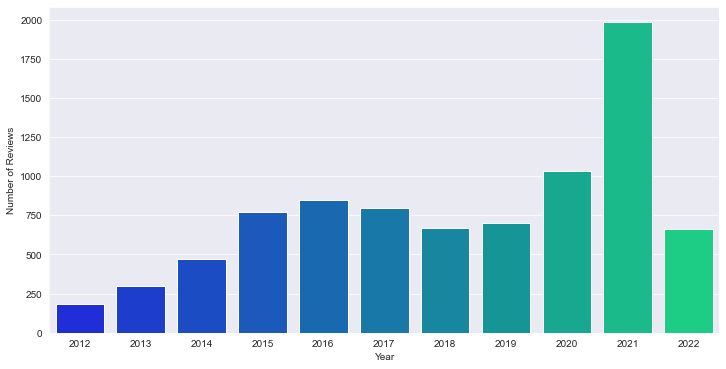

    year  count_normalized
0   2012              2.20
1   2013              3.54
2   2014              5.57
3   2015              9.18
4   2016             10.09
5   2017              9.46
6   2018              7.97
7   2019              8.30
8   2020             12.27
9   2021             23.55
10  2022              7.88


In [89]:
reviews_by_year(reviews)

#### Reviews per year + quits 

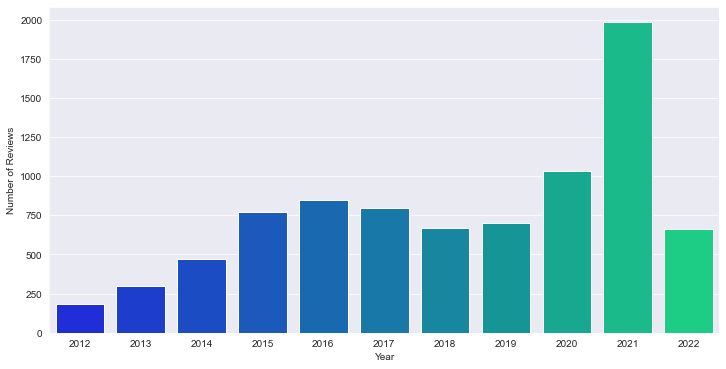

In [90]:
temp_df = reviews.copy()
temp_df['year'] = temp_df.date.apply(lambda x: x.year)
count_year = temp_df.groupby('year').company.count().reset_index()
count_year['count_normalized'] = round(((count_year['company'] / count_year['company'].sum()) * 100),2)
plt.figure(figsize=(12,6))
sns.barplot(x = count_year.year, y=count_year.company, palette='winter')
plt.ylabel('Number of Reviews')
plt.xlabel('Year')
plt.show()

In [91]:
quits = pd.read_csv('quits.csv')
# quits.date = pd.to_datetime(quits.date)
# quits = quits.astype(int)
quits = quits[:-1]
quits = quits.fillna(0)
quits = quits.astype(int)
quits.set_index('Year', inplace=True)
stacked = quits.stack()

In [93]:
quits_dict = {}
for row in quits.iterrows():
    year = row[0]
    months = row[1].index.values
    values = row[1].values
    for i in range(len(months)):
        month = months[i]
        value = values[i]
        date = f'{month}-{year}'
        quits_dict[date] = value
quits_dict

{'Jan-2012': 2030,
 'Feb-2012': 2130,
 'Mar-2012': 2167,
 'Apr-2012': 2134,
 'May-2012': 2138,
 'Jun-2012': 2152,
 'Jul-2012': 2072,
 'Aug-2012': 2069,
 'Sep-2012': 1950,
 'Oct-2012': 2035,
 'Nov-2012': 2078,
 'Dec-2012': 2051,
 'Jan-2013': 2280,
 'Feb-2013': 2298,
 'Mar-2013': 2124,
 'Apr-2013': 2296,
 'May-2013': 2234,
 'Jun-2013': 2203,
 'Jul-2013': 2363,
 'Aug-2013': 2316,
 'Sep-2013': 2302,
 'Oct-2013': 2372,
 'Nov-2013': 2391,
 'Dec-2013': 2287,
 'Jan-2014': 2311,
 'Feb-2014': 2411,
 'Mar-2014': 2449,
 'Apr-2014': 2474,
 'May-2014': 2483,
 'Jun-2014': 2507,
 'Jul-2014': 2633,
 'Aug-2014': 2549,
 'Sep-2014': 2732,
 'Oct-2014': 2718,
 'Nov-2014': 2600,
 'Dec-2014': 2552,
 'Jan-2015': 2764,
 'Feb-2015': 2741,
 'Mar-2015': 2754,
 'Apr-2015': 2705,
 'May-2015': 2743,
 'Jun-2015': 2756,
 'Jul-2015': 2764,
 'Aug-2015': 2879,
 'Sep-2015': 2778,
 'Oct-2015': 2810,
 'Nov-2015': 2897,
 'Dec-2015': 3056,
 'Jan-2016': 2875,
 'Feb-2016': 2994,
 'Mar-2016': 2917,
 'Apr-2016': 2955,
 'May-2016':

In [94]:
final = pd.DataFrame.from_dict(quits_dict.items()).rename(columns={0:'date',1:'quits'})
final.date = pd.to_datetime(final.date)

In [95]:
final

date  quits
0   2012-01-01   2030
1   2012-02-01   2130
2   2012-03-01   2167
3   2012-04-01   2134
4   2012-05-01   2138
..         ...    ...
127 2022-08-01      0
128 2022-09-01      0
129 2022-10-01      0
130 2022-11-01      0
131 2022-12-01      0

[132 rows x 2 columns]

In [96]:
final['year'] = final.date.apply(lambda x: x.year)
quits_per_year = final.groupby('year').quits.sum().reset_index()
quits_per_year

year  quits
0   2012  25006
1   2013  27466
2   2014  30419
3   2015  33647
4   2016  35869
5   2017  37737
6   2018  40371
7   2019  42207
8   2020  35791
9   2021  47845
10  2022  17515

In [97]:
combined = count_year.merge(quits_per_year, on='year', how='inner')

In [98]:
combined_scaled = combined.copy()
combined_scaled['reviews'] = (combined.company - combined.company.min()) / (combined.company.max() - combined.company.min())
combined_scaled['quits'] = (combined.quits - combined.quits.min()) / (combined.quits.max() - combined.quits.min())
combined_scaled

year  company  count_normalized     quits   reviews
0   2012      185              2.20  0.246983  0.000000
1   2013      298              3.54  0.328091  0.062848
2   2014      469              5.57  0.425453  0.157953
3   2015      773              9.18  0.531883  0.327030
4   2016      850             10.09  0.605143  0.369855
5   2017      797              9.46  0.666733  0.340378
6   2018      671              7.97  0.753577  0.270300
7   2019      699              8.30  0.814111  0.285873
8   2020     1033             12.27  0.602572  0.471635
9   2021     1983             23.55  1.000000  1.000000
10  2022      664              7.88  0.000000  0.266407

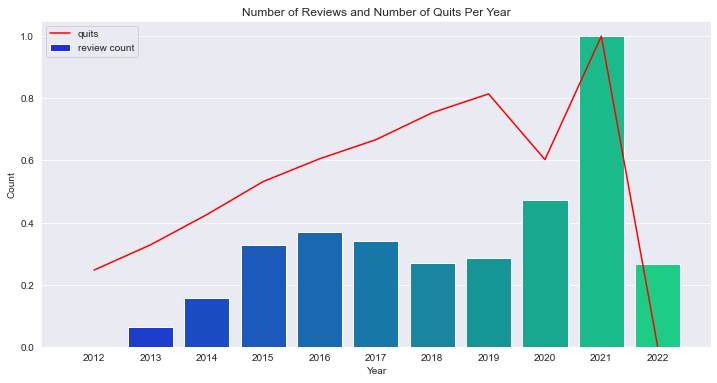

In [99]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x = combined_scaled.year, y=combined_scaled.reviews, palette='winter', ax=ax, label='review count')
# ax2 = ax.twinx()
sns.lineplot(data=combined_scaled, x=ax.get_xticks(), y="quits", ax=ax, color='r', label='quits')
plt.title('Number of Reviews and Number of Quits Per Year')
plt.ylabel('Count')
plt.xlabel('Year')
plt.show()

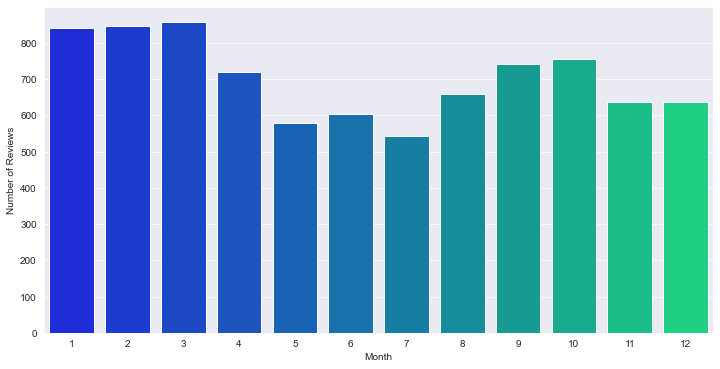

    month  count_normalized
0       1             10.00
1       2             10.06
2       3             10.18
3       4              8.54
4       5              6.87
5       6              7.18
6       7              6.45
7       8              7.81
8       9              8.81
9      10              8.96
10     11              7.56
11     12              7.58


In [100]:
reviews_by_month(reviews)

* Reviews spiked in 2021
* ~2X as many reviews in 2021 than in 2020 
* More reviews in Q1 than in other times of the year 

## Who are the top firms?

In [101]:
# TODO create a method for rankings called get_rankings, so that code isn't repeated

In [102]:
# what are the average ratings per company? 
review_rankings = reviews.groupby('company').mean_rating.mean().reset_index().sort_values(by='mean_rating', ascending=False)

# how many reviews per company? 
review_counts = reviews.groupby('company').review_count.mean().reset_index().sort_values(by='review_count',ascending=True)
review_counts.review_count = review_counts.review_count.apply(lambda x: int(x))

# merge together
company_rankings = review_rankings.merge(review_counts, left_on='company', right_on='company')

# remove companies with less than 100 reviews
company_rankings = remove_reviews(company_rankings,count=100)
top_25 = list(company_rankings[:25].company)
company_rankings[:25]



Removing following companies with less than 100 reviews:
['Acadian', 'Advent', 'American Capital', 'Angelo Gordon', 'Balyasny Asset Management', 'CVC', 'Cerberus', 'HarbourVest Partners, LLC', 'Sculptor Capital', 'Silver Lake', 'Warburg Pincus']


company  mean_rating  review_count
1                     Two Sigma     4.300000           110
3                   Jane Street     4.256250           160
4                       DE Shaw     4.250000           128
5                  Jump Trading     4.250000           112
6                  Bain Capital     4.120000           150
7                     Techstars     4.120000           100
9                           KKR     4.036842           190
11         The Blackstone Group     3.990123           405
14                      Point72     3.873469           245
15                      Sequoia     3.853333           150
17                    Man Group     3.806250           160
18            The Carlyle Group     3.801020           196
19   Oaktree Capital Management     3.792308           130
20              CPP Investments     3.768293           328
21       AQR Capital Management     3.743750           160
22                   Millennium     3.705000           200
23                      Citadel     3.703163           411
24                          TPG     3.700000           160
25       Bessemer Trust Company     3.672727           110
27               Boston Private     3.636364           110
28                    Neuberger     3.611621           327
29             Neuberger Berman     3.604938           324
30              Ares Management     3.589474           190
31  Brookfield Asset Management     3.560870           230
32    Fortress Investment Group     3.558140           129

### Are there any differences in rankings since pandemic? 

In [103]:
# create df for recent reviews 
recent_reviews = reviews[reviews.date > '2020-03-01'] 

# what are the average ratings per company? 
review_rankings_pandemic = recent_reviews.groupby('company').overall_rating.mean().reset_index().rename(columns={'overall_rating':'mean_rating'}).sort_values(by='mean_rating', ascending=False)

# how many reviews per company? 
review_counts_pandemic = recent_reviews.groupby('company').review_count.count().reset_index().sort_values(by='review_count',ascending=True)

# merge together
company_rankings_pandemic = review_rankings_pandemic.merge(review_counts_pandemic, left_on='company', right_on='company')

# remove companies with less than 100 reviews
# company_rankings_pandemic = remove_reviews(company_rankings_pandemic,count=40)
company_rankings_pandemic[company_rankings_pandemic.company.apply(lambda x: x in top_25)]

company  mean_rating  review_count
2                       DE Shaw     4.428571            42
5                           KKR     4.362500            80
6                     Two Sigma     4.271186            59
9                  Jump Trading     4.222222            45
10                  Jane Street     4.168317           101
11                 Bain Capital     4.109589            73
13                    Neuberger     4.031746           126
14         The Blackstone Group     4.030973           226
15             Neuberger Berman     4.024390           123
16                    Man Group     4.011905            84
17               Boston Private     4.000000            27
19              Ares Management     3.978495            93
20                      Sequoia     3.957447            47
21                    Techstars     3.925926            54
22                          TPG     3.909091            66
23       Bessemer Trust Company     3.894737            38
24   Oaktree Capital Management     3.867925            53
25                      Point72     3.848485            99
26       AQR Capital Management     3.810811            74
28            The Carlyle Group     3.790123            81
31    Fortress Investment Group     3.785714            42
33              CPP Investments     3.707317           164
34                   Millennium     3.702479           121
36  Brookfield Asset Management     3.684211           114
39                      Citadel     3.631868           182

Interpretation: There doesn't appear to be any differences since the pandemic with overall rankings 

## How have companies been rated over time? 
* For the past 10 years, what do the trends look like? 
* How have companies done in the pandemic? 

In [104]:
reviews.company.unique()

array(['Acadian', 'Advent', 'American Capital', 'Angelo Gordon',
       'Apollo Global Management', 'AQR Capital Management',
       'Ares Management', 'Bain Capital', 'Balyasny Asset Management',
       'Bayview Asset Management', 'Bessemer Trust Company',
       'Boston Private', 'Bridgewater', 'Brookfield Asset Management',
       'Cerberus', 'Citadel', 'CPP Investments', 'CVC', 'DE Shaw',
       'Fortress Investment Group', 'Geller & Company',
       'HarbourVest Partners, LLC', 'Intellectual Ventures',
       'Jane Street', 'Janus Capital', 'Jump Trading', 'KKR',
       'Lord Abbett & Co.', 'Man Group', 'Millennium', 'Moelis & Company',
       'Neuberger Berman', 'Neuberger', 'Oaktree Capital Management',
       'Oppenheimer Holdings', 'PIMCO', 'PineBridge Investments',
       'Point72', 'Putnam Investments', 'Sculptor Capital', 'Sequoia',
       'Silver Lake', 'SoftBank', 'Techstars', 'The Blackstone Group',
       'The Carlyle Group', 'TPG', 'Two Sigma', 'Warburg Pincus'],
     

In [105]:
""" 
For seeing trends for multiple companies 
Plot average yearly rating of a list of companies on one plot 
input: df of companies with ratings, number of colums for plot (optional), figure size for plot (optional)
output: group of subplots with line charts visualizing yearly overall rating of companies 
"""
def plot_company_rankings_yearly(df, num_cols=4, figsize=(25,15)):
    # get the list of companies and number of plots 
    company_lst = df.company.unique()
    total_subplots = len(company_lst) 
    cols = num_cols 
    rows = total_subplots // cols
    if total_subplots % cols > 0:
        rows+=1
    print(f"Total plots: {total_subplots}, Total cols: {cols}, Total rows: {rows}")
    
    # set index to 0, index is used for iterating through the company list 
    index=0
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize) 
    for row in range(axes.shape[0]):
        for col in range(axes.shape[1]):
            # delete plots that are not going to be used 
            if index >= total_subplots:
                fig.delaxes(axes[row,col])
                index+=1
            else: 
                ax = axes[row,col] 
                # get company df for plotting 
                company_name = company_lst[index] 
                company_df = df[df.company==company_name]
                company_df['year'] = company_df.date.apply(lambda x: x.year)
                rating_per_year = company_df.groupby('year').overall_rating.mean().reset_index()
                # plot the company on the right ax 
                rating_per_year.plot(x='year',y='overall_rating',ax=ax)
                ax.set_title(f'{company_name} ratings')
                ax.set_xticks(rating_per_year.year)
                ax.set_xticklabels(rating_per_year.year)
    #             ax.axis('off')
                index += 1

    plt.tight_layout()


""" 
For zooming in on one company 
Plot average yearly rating of a single company
output: line chart 
"""
def plot_ranking_yearly(df, company):
    company_df = df[df.company==company]
    company_df['year'] = company_df.date.apply(lambda x: x.year)
    rating_per_year = company_df.groupby('year').overall_rating.mean().reset_index()
    
    fig, ax = plt.subplots(figsize=(12,6))
    rating_per_year.plot(x='year',y='overall_rating',ax=ax)
    ax.set_title(f'{company} ratings')
    ax.set_xticks(rating_per_year.year)
    ax.set_xticklabels(rating_per_year.year)
    
    plt.show()

Total plots: 49, Total cols: 4, Total rows: 13


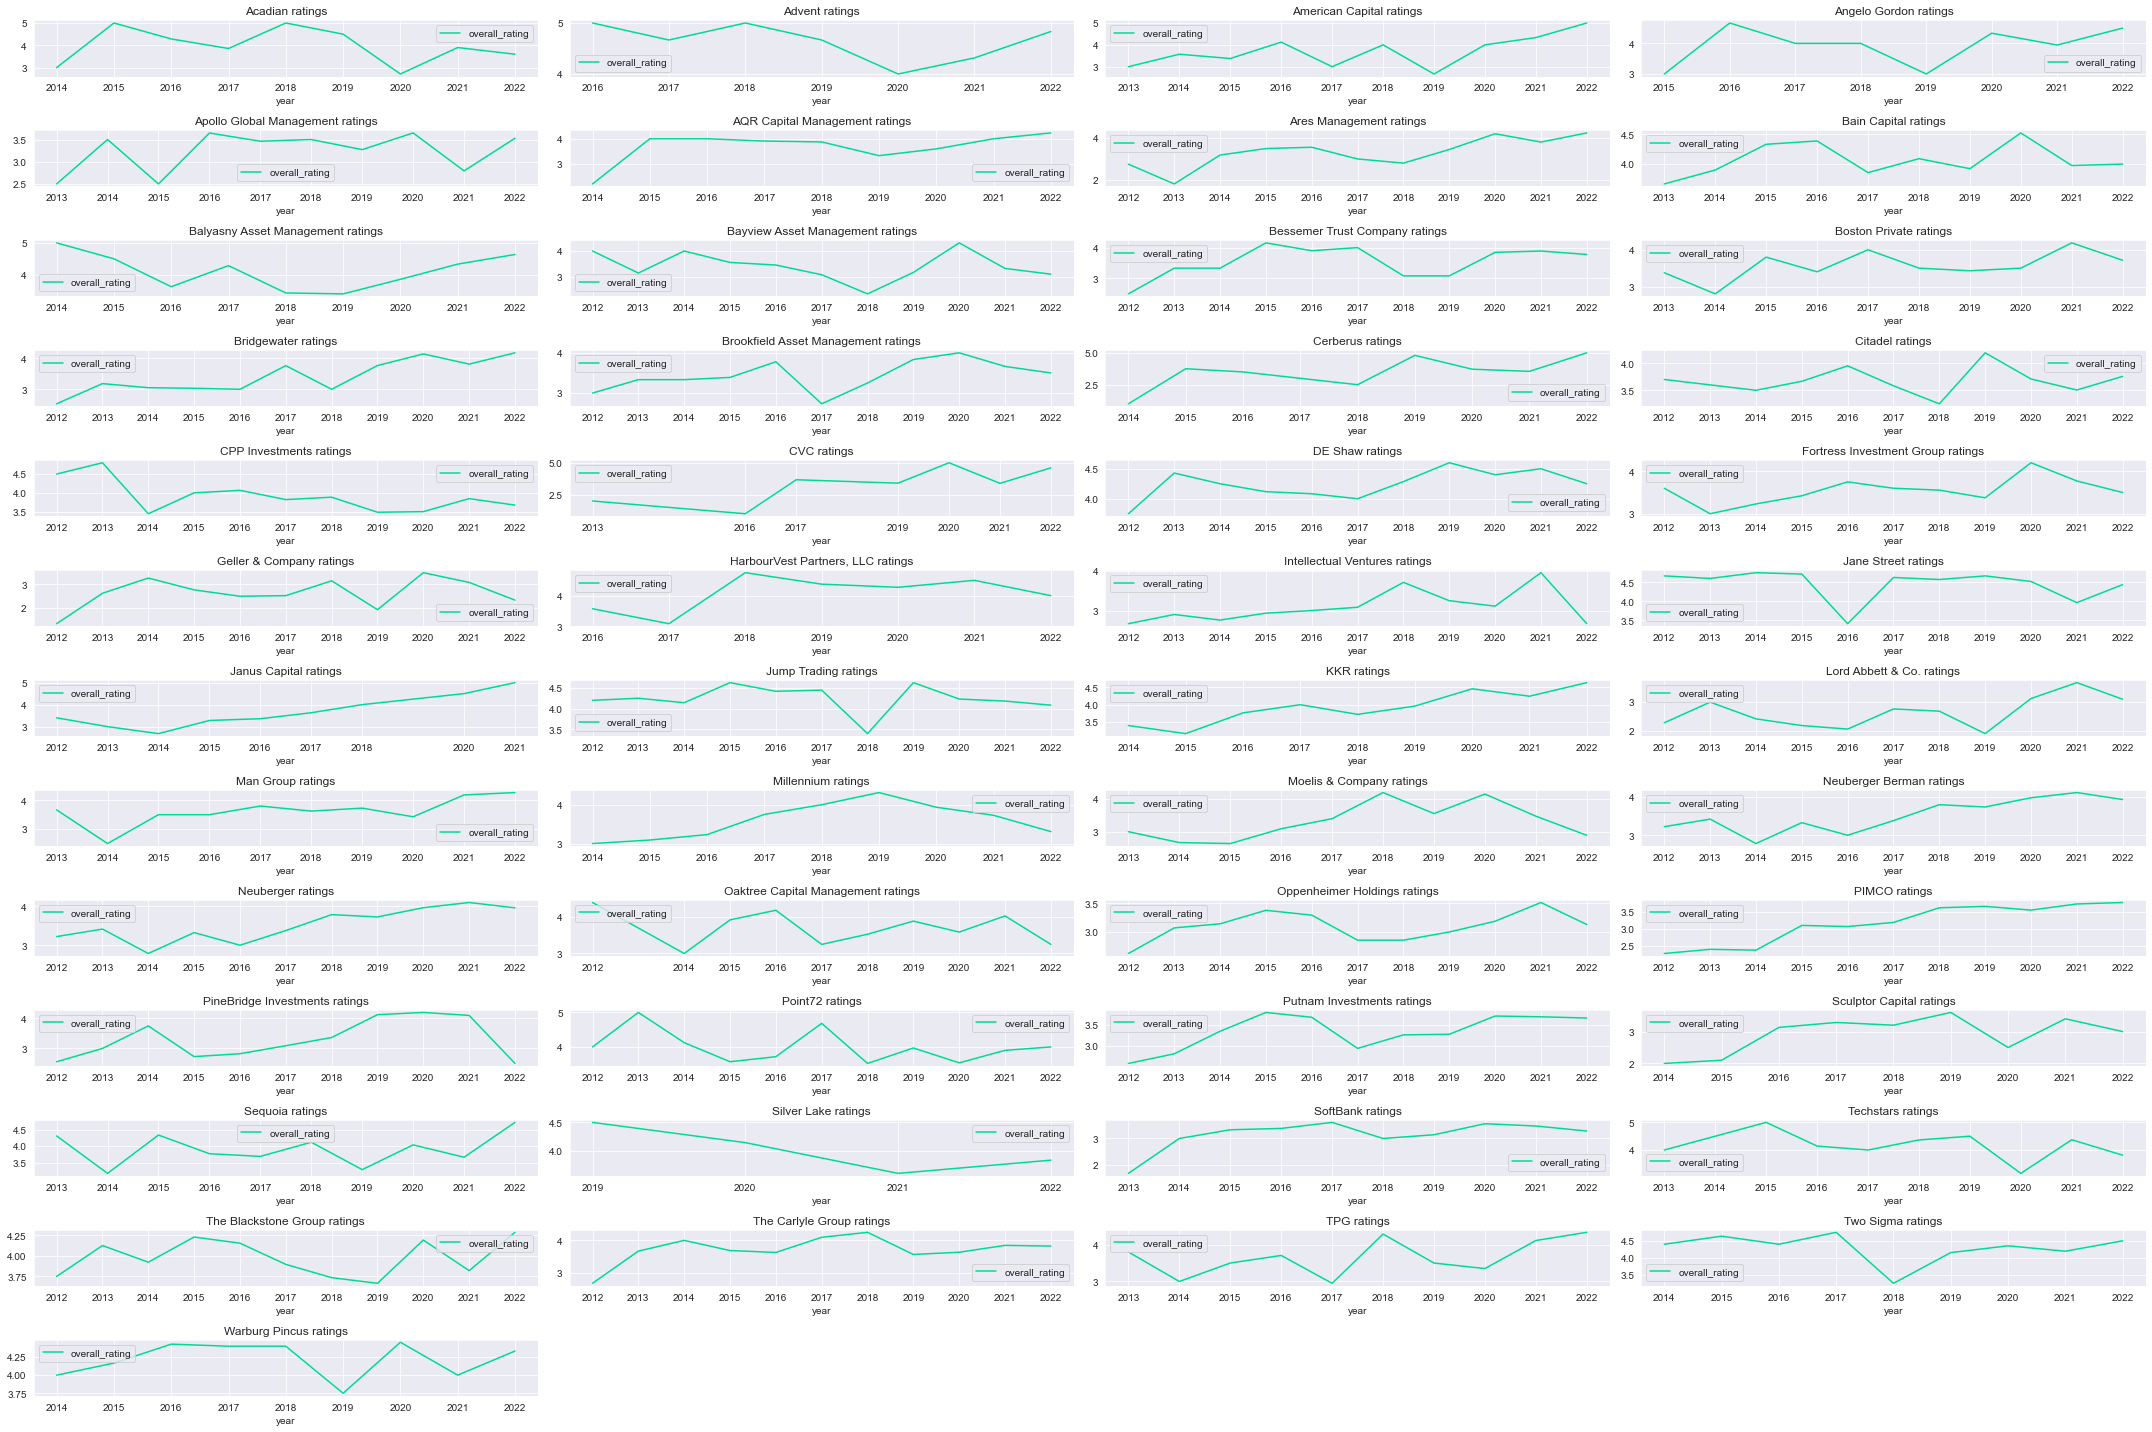

In [106]:
plot_company_rankings_yearly(reviews, figsize=(30,20))

These companies look like they are trending in a negative direction, especially since the pandemic:
* Intellectual Ventures 
* Lord Abbett 
* Fortress
* Brookfield 
* Moelis 

These companies look like they are trending in a positive direction, especially since the pandemic:
* Jane Street
* Ares Management  
* KKR 
* Warburg Pincus 
* Citadel 

Further investigation to follow in coming steps. 

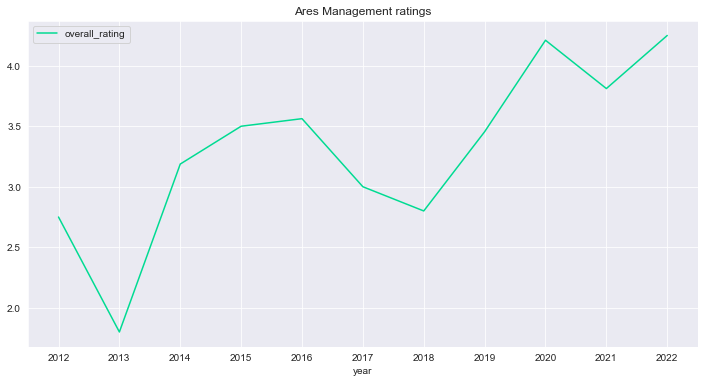

In [107]:
plot_ranking_yearly(reviews, 'Ares Management')

### How have these companies done during the pandemic? 

* Intellectual Ventures 
* Lord Abbett 
* Fortress
* Brookfield 
* Moelis 

These companies look like they are trending in a positive direction, especially since the pandemic:
* Jane Street
* Ares Management  
* KKR 
* Warburg Pincus 
* Citadel 

In [108]:
""" 
For seeing trends for multiple companies and zooming in during the pandemic 
Plot average monthly rating of a list of companies on one plot 
input: df of companies with ratings, number of colums for plot (optional), figure size for plot (optional)
output: group of subplots with line charts visualizing yearly overall rating of companies 
"""
def plot_company_rankings_pandemic(df, company_lst, num_cols=4, figsize=(25,15)):
    # get the list of companies and number of plots 
    total_subplots = len(company_lst) 
    rows = total_subplots // num_cols

    if total_subplots % num_cols > 0:
        rows+=1
    print(f"Total plots: {total_subplots}, Total cols: {num_cols}, Total rows: {rows}")

    # set index to 0, index is used for iterating through the company list 
    index=0
    fig, axes = plt.subplots(nrows=rows, ncols=num_cols, figsize=(48,6)) 
    # if there are more than 1 row 
    if axes.size > num_cols:
        for row in range(axes.shape[0]):
            for col in range(axes.shape[1]):
                # delete plots that are not going to be used 
                if index >= total_subplots:
                    fig.delaxes(axes[row,col])
                    index+=1
                else: 
                    ax = axes[row,col] 
                    # get company df for plotting 
                    company_name = company_lst[index] 
                    company_df = df[df.company==company_name]
                    company_df['mon_year'] = company_df.date.dt.to_period('M')
                    rating_per_year = company_df.groupby('mon_year').overall_rating.mean()
                    # plot the company on the right ax 
                    rating_per_year['2020':].plot(x='year',y='overall_rating',ax=ax)
                    ax.set_title(f'{company_name} ratings')
                    #                 ax.set_xticks(rating_per_year['2020':].index)
                    #                 ax.set_xticklabels(rating_per_year['2020':].index, rotation=30)
                    #             ax.axis('off')
                    index += 1
     # if there's only 1 row 
    else:
        for col in range(axes.shape[0]):
            if index >= total_subplots:
                fig.delaxes(axes[row])
                index += 1
            else:
                ax = axes[row] 
                # get company df for plotting 
                company_name = company_lst[index] 
                company_df = df[df.company==company_name]
                company_df['mon_year'] = company_df.date.dt.to_period('M')
                rating_per_year = company_df.groupby('mon_year').overall_rating.mean()
                # plot the company on the right ax 
                rating_per_year['2020':].plot(x='year',y='overall_rating',ax=ax)
                ax.set_title(f'{company_name} ratings')
                index += 1

    plt.tight_layout()

def plot_ranking_pandemic(df, company):
    company_df = df[df.company==company]
    company_df['mon_year'] = company_df.date.dt.to_period('M')
    rating_per_year = company_df.groupby('mon_year').overall_rating.mean()
    fig, ax = plt.subplots(figsize=(12,6))
    ts = rating_per_year['2020':]
    ts = ts.resample('M').bfill()
    ts.plot(x='mon_year',y='overall_rating',ax=ax)
    ax.set_title(f'{company} ratings')
    ax.set_xticks(ts.index)
    ax.set_xticklabels(ts.index, rotation=30)
    plt.show()

Total plots: 5, Total cols: 4, Total rows: 2


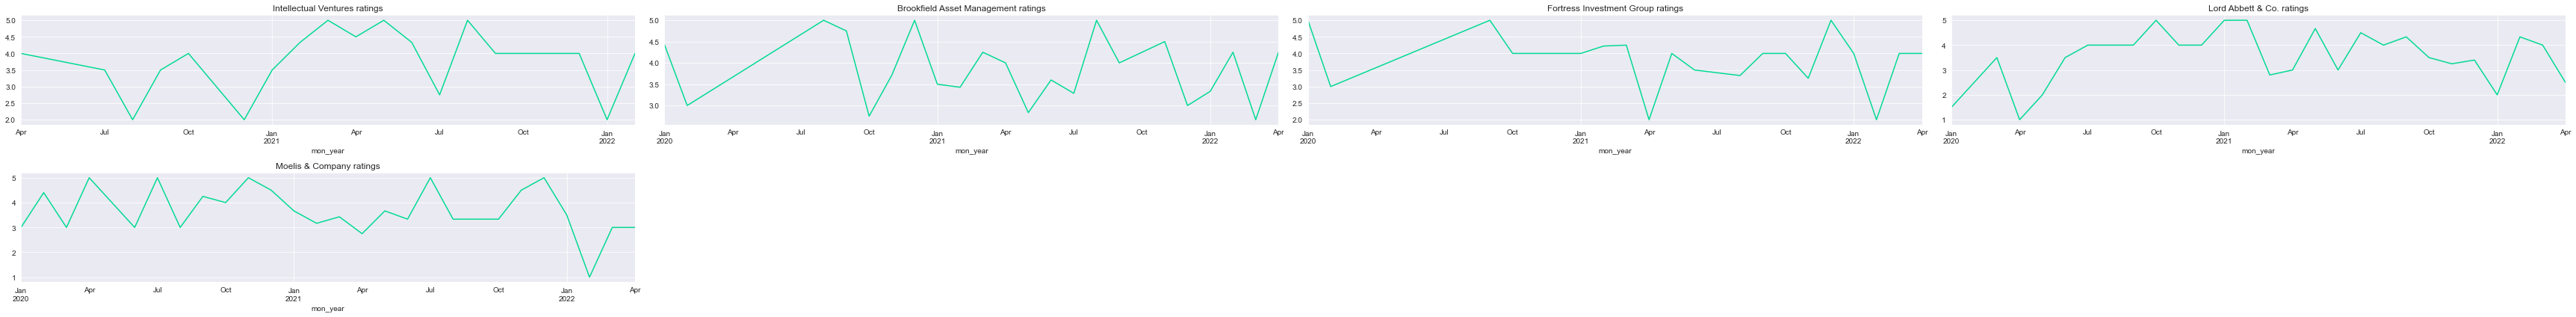

In [109]:
negative_trending_companies = ['Intellectual Ventures', 'Brookfield Asset Management', 'Fortress Investment Group', 'Lord Abbett & Co.','Moelis & Company']
positive_trending_companies = ['Jane Street','Ares Management','KKR','Warburg Pincus', 'Citadel']
plot_company_rankings_pandemic(reviews, negative_trending_companies)

In [110]:
# fig, ax = plt.subplots(figsize=(18,6)) 
# for company in company_lst:
#     # get company reviews for plotting 
#     company_data = reviews[reviews.company==company]
#     company_data['mon_year'] = company_data.date.dt.to_period('M')
#     rating_per_year = company_data.groupby('mon_year').overall_rating.mean()
#     # plot the company on the right ax 
#     rating_per_year['2020':].plot(x='mon_year',y='overall_rating',ax=ax, label=f'{company}')
#     plt.title('Company ratings per year')
# #     ax.set_xticks(rating_per_year.year)
# #     ax.set_xticklabels(rating_per_year.year)
# plt.legend()
# plt.show()

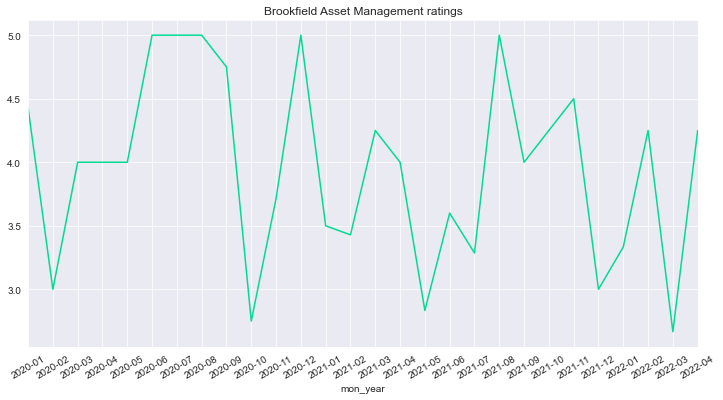

In [111]:
plot_ranking_pandemic(reviews, 'Brookfield Asset Management')

##  Are different types of employees feeling more or less valued? (analyze by position) 


In [112]:
"""testing"""
# reviews[reviews.author_position.apply(lambda x: 'legal' in x.lower())]
# reviews[(reviews.position_department == 'other') & (reviews.author_position.apply(lambda x: 'anonymous' not in x.lower()))][-50:]

'testing'

In [113]:
rating_by_dept = reviews.groupby('position_department').overall_rating.mean().reset_index().sort_values(by='overall_rating', ascending=False)
count_by_dept = reviews.groupby('position_department').pros.count().reset_index().rename(columns={'pros':'count'})
rating_by_dept.merge(count_by_dept, left_on='position_department', right_on='position_department')

position_department  overall_rating  count
0                  intern        4.295652    115
1              investment        3.785235   1192
2              technology        3.715278    864
3          hr_admin_legal        3.622530    506
4  accounting_finance_ops        3.614880    457
5                   other        3.565068   4941
6         marketing_sales        3.547550    347

In [114]:
# TODO add count to this as well, so you can see how many reviews per level 
reviews.groupby('position_level').overall_rating.mean().reset_index().sort_values(by='overall_rating', ascending=False)

position_level  overall_rating
1         senior        3.715618
0          other        3.617002

# II. Text Preprocessing

* Using Regex & NLTK libraries
* Noise Removal – Removing unnecessary characters and formatting
* Tokenization – break multi-word strings into smaller components
* Normalization – a catch-all term for processing data; this includes stemming and lemmatization
    * Upper or lowercasing
    * Stopword removal
    * Stemming – bluntly removing prefixes and suffixes from a word
    * Lemmatization – replacing a single-word token with its root

In [115]:
# TODO keep reviews with only less than 100 words? 
# # remove reviews with too many words in pros column  
# print(f'There are {len(reviews[reviews.pros.apply(lambda x: len(x.split()) > 100)])} reviews with more than 100 words.')
# reviews = reviews[reviews.pros.apply(lambda x: len(x.split()) < 100)]

## Define Methods

In [344]:
# TODO find a better way to remove companies ie: BX, blackstone, blackstone group

# https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/

def preprocess_text(text, company_list, display=False):
    
    # remove html, hyphens, numbers 
    r_unwanted = re.compile("(\\.)|(\s-)|(^-)|(\d)|([+])|(\s[\'\"])|([\'\"]\s)")

    # make all words lowercase, and sub in regex  
    text = r_unwanted.sub(' ',text.lower())
    if display:
        print("First pass: ", text,"\n")

    # remove mentions of company 
    for company in company_list:
        text = text.replace(company, "")
    
    # remove mentions for class of firm 
    for fund in ['hedge fund','private equity','pe fund', 'asset manager']:
        text = text.replace(fund,"")
        
    # coworker should be one word 
    text = text.replace("co-worker","coworker")
    text = text.replace("co worker","coworker")

    # contractions 
    text = text.replace("’","'")
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokens_raw = nltk.regexp_tokenize(text, pattern)
    expanded_tokens = [w for word in tokens_raw for w in contractions.fix(word).split()]
    if display:
        print('Tokens Raw: ', tokens_raw)
        print('Expanded Tokens: ', expanded_tokens)

    # create a stopwords list including numbers and punctuation
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += ['there\'s',"'s", 'n\'t', '\'ve','\'m','’',"lot", 'lots','cannot']
    stopwords_list += ['pe','fund']

    # tokenize words and remove possessives ('s)
    text_lst = [word.replace("'s","") for word in expanded_tokens if word not in stopwords_list and len(word) > 1]
    if display:    
        print("Stopwords removed: ", text_lst,"\n")
        
    # lemmatize words 
    lemmatizer = WordNetLemmatizer()
    lemmatized_lst = [lemmatizer.lemmatize(word) for word in text_lst]
    if display:
        print("lemmatized: ", lemmatized_lst,"\n")

    # combine into one string from list                                      
    final_lst = " ".join(lemmatized_lst)
    return final_lst



def get_company_list(df):
    final_lst = []
    for company in df.company.unique():
        final_lst.append(company.lower())
    return final_lst



In [345]:
# with open('investment_company_reviews_df.pickle', 'rb') as f:
#     df = pickle.load(f)

In [346]:
# company_list = get_company_list(top_recent_reviews)
# test_review = "I'm proud to work at Atlassian because"
# preprocess_text(test_review, company_list)

# """ TESTING """
# stopwords_list = stopwords.words('english')
# stopwords_list += list(string.punctuation)
# stopwords_list += ['there\'s',"'s", 'n\'t', '\'ve','\'m','’',"lot", 'lots']
# stopwords_list

# # test = df[df.headline == 'Run for the hills'].pros.values[0]
# test = df[df.pros.apply(lambda x: 'can\'t' in x)].pros.iloc[0]
# preprocess_text(test, company_list)

In [347]:
company_list = get_company_list(reviews)
amended = ['bx','lord abbett','abbett','apollo','agi','harbourvest',
                     'aqr','ares','moelis','sculptor','pinebridge','putnam','blackstone',
                     'brookfield','cpp','bp','balyasny','bayview','bain','allianz']
company_list = company_list + amended

In [348]:
df = reviews.copy()
df['pros_cleaned'] = df['pros'].apply(lambda x: preprocess_text(x, company_list))
df['cons_cleaned'] = df['cons'].apply(lambda x: preprocess_text(x, company_list))
df['headline_cleaned'] = df['headline'].apply(lambda x: preprocess_text(x, company_list))
df['combined_text'] = df['pros_cleaned'] + " " + df['cons_cleaned'] + " " + df['headline_cleaned']


# with open('investment_company_reviews_df.pickle', 'wb') as f:
#     pickle.dump(df, f)

In [349]:
df_pandemic = df[df.date > '2020']

In [343]:
"""testing"""
# df[df.pros_cleaned.apply(lambda x: 'lot' in x.lower())]

# test = test.replace('GI', "")
# test

test = df[df.pros_cleaned.apply(lambda x: 'worker' in x.lower())].iloc[3]['pros']
print(test)
preprocess_text(test, company_list, display=True)

If you are interested in PE or alternative assets, this is the company to work for in the Washington D.C. area.  Great co-workers, good pay, 100% covered medical/dental benefits, decent vacation time, free iPhone, and gain experience from smart people.  Good hours - expect to work 50 to 60 + hours/week.
First pass:  if you are interested in pe or alternative assets, this is the company to work for in the washington d c  area   great co-workers, good pay,    % covered medical/dental benefits, decent vacation time, free iphone, and gain experience from smart people   good hours  expect to work    to      hours/week  

Tokens Raw:  ['if', 'you', 'are', 'interested', 'in', 'pe', 'or', 'alternative', 'assets', 'this', 'is', 'the', 'company', 'to', 'work', 'for', 'in', 'the', 'washington', 'd', 'c', 'area', 'great', 'co', 'workers', 'good', 'pay', 'covered', 'medical', 'dental', 'benefits', 'decent', 'vacation', 'time', 'free', 'iphone', 'and', 'gain', 'experience', 'from', 'smart', 'people'

'interested alternative asset company work washington area great co worker good pay covered medical dental benefit decent vacation time free iphone gain experience smart people good hour expect work hour week'

# III. Words Analysis

* Pros Column
* Cons Column 
* Has sentiment shifted since the pandemic? 

## Define Methods

In [ ]:
# TODO - do investment professionals show different words? 

In [350]:
""" BIGRAMS and COMMON WORDS"""


"""
Deprecated 
get list of lists of tokenized blobs of text 
alternate - use nltk word_tokenize 
"""
# def get_corpus_lst(corpus):
#     lst_corpus = []
#     for string in corpus:
#         lst_words = string.split()
#         lst_grams = [" ".join(lst_words[i:i+1]).encode() for i in range(0, len(lst_words), 1)]
#         lst_corpus.append(lst_grams)
#     return lst_corpus


"""
Takes in a list of tokens 
Displays most common num words and their frequency 
"""
def most_common_words(tokens, num, display=True):
    freqdist = FreqDist(tokens)
    most_common = freqdist.most_common(num)

    total_word_count = len(tokens) # equivalent to sum(freqdist.values())
    if display:
        print(f'There are {len(freqdist)} words in the vocabulary of corpus, after stopwords have been removed.\n')
        print('Normalized Frequency\n')
        for word in most_common:
            normalized_freq = word[1] / total_word_count
            print(f'{word[0]}: {normalized_freq}')
        # get all tokens to check for frequency, not unique tokens  

"""
Takes in a list of lists (tokenized blobs of text)
Output list of lists with bigrams and trigrams 
https://radimrehurek.com/gensim/models/phrases.html
"""  

# TODO check to see if it's able to change how it detects bigrams - ie: can we use PMI instead of raw frequency 
def get_bigrams_trigrams(lst_corpus):
    """
    min_count (float, optional): Ignore all words and bigrams with total collected count lower than this value.

    threshold (float, optional) – 
    Represent a score threshold for forming the phrases (higher means fewer phrases). 
    A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold. 
    Heavily depends on concrete scoring-function, see the scoring parameter.
    """
    
    
    bigrams_detector = Phrases(lst_corpus, delimiter=" ", min_count=5, threshold=5)
    bigrams_phraser = Phraser(bigrams_detector)

    trigrams_detector = Phrases(bigrams_detector[lst_corpus], delimiter=" ", min_count=5, threshold=5)
    trigrams_phraser = Phraser(trigrams_detector)
    
    lst_bigrams = list(bigrams_phraser[lst_corpus]) # equivalent to list(bigrams_detector[lst_corpus_pros])
    lst_final = list(trigrams_phraser[lst_bigrams])
    
    return lst_final

"""
Display bigrams from text using two approaches - frequency and PMI score 
Input: take in a list of tokens (list of tokenized blobs needs to be flattened into only words)
Also specify the number of bigrams to display, default = 10 
output: print top 10 bigrams for both approaches 
"""
def display_bigrams(tokens, num_bigrams=10):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokens)
    bigrams_scored = finder.score_ngrams(bigram_measures.raw_freq)
    print('Top Bigrams Based on Raw Frequency: ')
    for bigram in bigrams_scored[:num_bigrams]:
        print(bigram)
    
    # display bigrams using PMI score 
    finder = BigramCollocationFinder.from_words(tokens)
    finder.apply_freq_filter(10)
    pmi_scored = finder.nbest(bigram_measures.pmi, 10)
    print('\nTop Bigrams Based on PMI: ')
    for bigram in pmi_scored[:num_bigrams]:
        print(bigram)

In [351]:
"""
FOR LDA TOPIC MODELING
"""

def get_coherence_scores(lda_model, texts, doc_term_matrix, dictionary, display=False):
    # get the coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    # get perplexity, lower the better 
    perplexity_score = lda_model.log_perplexity(doc_term_matrix)
   
    if display:
        print(f'Coherence Score: {coherence_score}')
        print(f'Perplexity: {lda_model.log_perplexity(doc_term_matrix)}')
        
    return coherence_score, perplexity_score

"""
using the dictionary with ids 
convert into doc term matrix 
converts each blob of text into a list of word ids and frequencies 
doc_term_matrix[24] output: [(71, 1)]
"""

def get_id2word_doc_matrix(lst_corpus):
    # every unique term assigned an index
    id2word = Dictionary(lst_corpus)
    # using the dictionary with ids converts each blob into a list of word ids and frequencies 
    doc_term_matrix = [id2word.doc2bow(r) for r in lst_corpus]
    return id2word, doc_term_matrix

"""
get optimal number of topics based on coherence scores 
use LDA multicore to use more threads 
input: doc term matrix, dictionary, list of tokenized docs, min number of topics, 
max number of topics to search, display (visualization of coherence scores)
output: dataframe with coherence scores and number of topics 
""" 
def find_optimal_topics(doc_term_matrix, id2word, lst_corpus, min_topics=1, max_topics=50, display=True):
    
    num_topics = np.arange(min_topics,max_topics+1,1) # 1 to 50 topics 
    
    coherence_scores = []
    for i in num_topics:
        lda_model = LdaMulticore(corpus=doc_term_matrix, id2word=id2word, num_topics=i, passes=10, workers=2, random_state=123)
        coherence_score = get_coherence_scores(lda_model, lst_corpus, doc_term_matrix, id2word)[0]
        coherence_scores.append(coherence_score)
    
    if display:
        plt.figure(figsize=(12,6))
        plt.title('Coherence Scores vs. Number of Topics')
        plt.xlabel('Number of Topics')
        plt.ylabel('Coherence Scores')
        sns.lineplot(x=num_topics, y=coherence_scores)
        plt.show()
        
    return pd.DataFrame(list(zip(num_topics, coherence_scores)), columns=['num_topics', 'coherence_score']).sort_values(by='coherence_score', ascending=False)
    
# def get_coherence_scores(lst_corpus, min_topics=1, max_topics=50): 
#     id2word, doc_term_matrix = get_id2word_doc_matrix(lst_corpus)
    
#     coherence_scores = []
#     for i in num_topics:
#         lda_model = LdaMulticore(corpus=doc_term_matrix, id2word=id2word, num_topics=i, passes=10, workers=2, random_state=123)
#         coherence_score = get_coherence_scores(lda_model, lst_corpus, doc_term_matrix, id2word)[0]
#         coherence_scores.append(coherence_score)
    
#     return pd.DataFrame(list(zip(num_topics, coherence_scores)), columns=['num_topics', 'coherence_score']).sort_values(by='coherence_score', ascending=False)




"""
Plot multiple wordclouds based off of an LDA model 
input: lda model 
output: wordclouds plots of all topics, with top num_words words (default 20) from each topic 
"""

def plot_wordclouds_lda(lda_model, num_words=20):
    total_subplots = lda_model.num_topics
    cols = 4
    rows = total_subplots // cols
    if total_subplots % cols > 0:
        rows+=1
    print(f"Total plots: {total_subplots}, Total cols: {cols}, Total rows: {rows}")

    index=0
    fig,axes = plt.subplots(nrows=rows, ncols=cols, figsize=(25,15))
    index=0

    for row in range(axes.shape[0]):
        for col in range(axes.shape[1]):
            if index >= lda_model.num_topics:
                fig.delaxes(axes[row,col])
                index+=1
            else:
                wc_dict = dict(lda_model.show_topic(index,num_words))
                wc = WordCloud().fit_words(wc_dict)
                ax = axes[row,col]
                ax.set_title(f'Topic Number: {index+1}')
                im = ax.imshow(wc) #, interpolation='bilinear'
                ax.axis('off')
                index += 1

    plt.tight_layout()


    
""" Plot a single wordcloud for a topic number and a given number of words"""
def plot_wordcloud_lda(lda_model, topic_number, num_words=20):
    wc_dict = dict(lda_model.show_topic(topic_number,num_words))
    wc = WordCloud().fit_words(wc_dict)
    
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [352]:
"""
FOR GSDMM modeling
"""

"""
This will generate a list of the total number of clusters, 
with the top {num_words} most-recurring words, and the number of times each of those top {num_words} words occurs in the topic.
"""
def top_words_gsdmm(cluster_word_distribution, cluster_indexes_sorted, num_words):
    for idx in cluster_indexes_sorted:
        if len(gsdmm.cluster_word_distribution[idx]) == 0:
            continue
        # each k, v in the dictionary is a word, frequency. x[1] is the frequency, sort by this number, and only include the top {num_words} words
        word_dict = sorted(cluster_word_distribution[idx].items(), key=lambda x: x[1], reverse=True)[:num_words]
        print(f'Cluster {idx}: {word_dict}')

"""
Generate 1 wordcloud based on topic number 
"""
def generate_wordcloud(cluster_word_distribution, topic_number, num_words, width=1800, height=700):
    topic_dict = sorted(gsdmm.cluster_word_distribution[topic_number].items(), key=lambda x: x[1], reverse=True)[:num_words]
    topic_dict = {item[0]:item[1] for item in topic_dict}
    
    wordcloud = WordCloud(width=width, height=height).generate_from_frequencies(topic_dict)
    return wordcloud

# generate_wordcloud(gsdmm.cluster_word_distribution, 10, 20)    

"""TODO takes in a list of topic numbers and produces an array of wordclouds """

"""
Plot multiple wordclouds based off of a cluster word dist
input: gsdmm cluster word distribution, and list of indexes of docs sorted by importances 
output: wordclouds plots of all clusters with words in them, sorted by importance 

"""
def plot_wordclouds(cluster_word_distribution, indexes_sorted):
    topic_numbers = [idx for idx in indexes_sorted if len(cluster_word_distribution[idx]) > 0]

    total_subplots = len(topic_numbers)
    cols = 4
    rows = total_subplots // cols
    if total_subplots % cols > 0:
        rows+=1
    print(f"Total plots: {total_subplots}, Total cols: {cols}, Total rows: {rows}")

    index=0
    fig,axes = plt.subplots(nrows=rows, ncols=cols, figsize=(25,15))
    index=0

    for row in range(axes.shape[0]):
        for col in range(axes.shape[1]):
            if index >= len(topic_numbers):
                fig.delaxes(axes[row,col])
                index+=1
            else:
                wordcloud = generate_wordcloud(gsdmm.cluster_word_distribution, topic_numbers[index], 20)
                ax = axes[row,col]
                ax.set_title(f'Topic Number: {topic_numbers[index]}')
                im = ax.imshow(wordcloud) #, interpolation='bilinear'
                ax.axis('off')
                index += 1

    plt.tight_layout()
    
""" Plot a single wordcloud """
def plot_wordcloud(cluster_word_distribution, topic_number, num_words):
    wordcloud = generate_wordcloud(cluster_word_distribution, topic_number, num_words)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


## Analyzing Pros Column

1. Most common words 
2. Bigrams and trigrams 
3. LDA 
4. GSDMM 

In [353]:
# get text data from each relevant column dataframe 
# corpus_pros = df['pros_cleaned']
# create lists of tokenized lists 
# lst_corpus_pros = get_corpus_lst(df['pros_cleaned'])
lst_corpus_pros = df['pros_cleaned'].map(word_tokenize).values
lst_corpus_pros_pandemic = df_pandemic['pros_cleaned'].map(word_tokenize).values
tokens_pros = list(itertools.chain(*lst_corpus_pros))
tokens_pros_pandemic = list(itertools.chain(*lst_corpus_pros_pandemic))

### 1. Most common words 

In [237]:
# 1A. All Words

freqdist = FreqDist(tokens_pros)
total_vocab_len_pros = len(tokens_pros)
print(most_common_words(tokens_pros, 25, display=True))

# 1B. Pandemic

freqdist = FreqDist(tokens_pros_pandemic)
total_vocab_len_pros = len(tokens_pros_pandemic)
print(most_common_words(tokens_pros_pandemic, 25, display=True))

There are 5839 words in the vocabulary of corpus, after stopwords have been removed.

Normalized Frequency

great: 0.03209833150701925
work: 0.03207765625323051
good: 0.030041143755039593
people: 0.028366448198151633
benefit: 0.01625074947794984
company: 0.01364566750056857
culture: 0.01291169599106829
smart: 0.010058510968222134
environment: 0.009789732668968511
opportunity: 0.00974838216139103
team: 0.008631918456799057
employee: 0.007959972708665
pay: 0.007928959827981889
nice: 0.007505117125312713
place: 0.0069365476461223565
life: 0.006719457481340584
management: 0.00648169206277007
firm: 0.00641966630140385
working: 0.006264601897988298
balance: 0.006099199867678376
office: 0.006037174106312155
learn: 0.005251514462340025
get: 0.004962060909297661
compensation: 0.004693282610044038
free: 0.004641594475572187
None
There are 3288 words in the vocabulary of corpus, after stopwords have been removed.

Normalized Frequency

good: 0.040466779597214377
work: 0.036263253654558
great: 0.0

### 2. Bigrams 
* Display bigrams 

#### 2A. All Reviews

In [354]:
display_bigrams(tokens_pros)

Top Bigrams Based on Raw Frequency: 
(('work', 'life'), 0.005730837512069019)
(('life', 'balance'), 0.005658163847966695)
(('smart', 'people'), 0.0052221218633527475)
(('great', 'benefit'), 0.003633683205116226)
(('great', 'people'), 0.0030522938922976296)
(('good', 'work'), 0.0027304533798444782)
(('good', 'benefit'), 0.0027096894758152426)
(('place', 'work'), 0.0025851060516398293)
(('work', 'environment'), 0.0024916684835082693)
(('great', 'place'), 0.002294411395230531)

Top Bigrams Based on PMI: 
('cherry', 'creek')
('newport', 'beach')
('red', 'tape')
('town', 'hall')
('fixed', 'income')
('strength', 'weakness')
('track', 'record')
('dress', 'code')
('profit', 'sharing')
('cutting', 'edge')


The raw freq finder located bigrams related to culture: 
* people 
* work/life balance  
* benefits 

Interestingly, the PMI finder located some interesting bigrams related to:
* office (location and feel - dress code) 
* performance of the firm 
* benefits (tuition reimbursement) 

#### 2B. Pandemic

In [355]:
display_bigrams(tokens_pros_pandemic)

Top Bigrams Based on Raw Frequency: 
(('work', 'life'), 0.007429560837399654)
(('life', 'balance'), 0.007303636077443727)
(('smart', 'people'), 0.006516606327719188)
(('good', 'work'), 0.0037462616086888084)
(('great', 'people'), 0.003494412088776956)
(('good', 'pay'), 0.0034314497087989926)
(('good', 'benefit'), 0.0033684873288210293)
(('great', 'benefit'), 0.0033684873288210293)
(('place', 'work'), 0.003337006138832048)
(('great', 'culture'), 0.0030536754289312135)

Top Bigrams Based on PMI: 
('cutting', 'edge')
('diversity', 'inclusion')
('top', 'notch')
('deal', 'flow')
('fast', 'paced')
('entry', 'level')
('long', 'term')
('year', 'end')
('job', 'security')
('health', 'insurance')


Interestingly, the results of the PMI finder related to office and location disappear. Presumably during the pandemic these were less important benefits. Instead the focus is on culture, inclusion, retention, and health. 

### 3. LDA Topic Modeling 
* Pros: what are the latent topics within the pros column at top companies? 

In a nutshell, LDA assumes that each document is made up of a distribution of topics and that each topic is in turn made up of a distribution of words. Since we already have our documents (tweets) and our words, the task of the LDA algorithm, then, is to construct the hidden (‘latent’) layer that connects the two: the topics.



#### Get bigrams and trigrams 
* Get bigrams and trigrams for list corpus


In [356]:
lst_pros_final = get_bigrams_trigrams(lst_corpus_pros)
lst_pros_final_pandemic = get_bigrams_trigrams(lst_corpus_pros_pandemic)
# print(len(lst_pros_final), len(lst_corpus_pros))

#### 3A. All reviews

In [357]:
id2word_pros, doc_term_matrix_pros = get_id2word_doc_matrix(lst_pros_final)


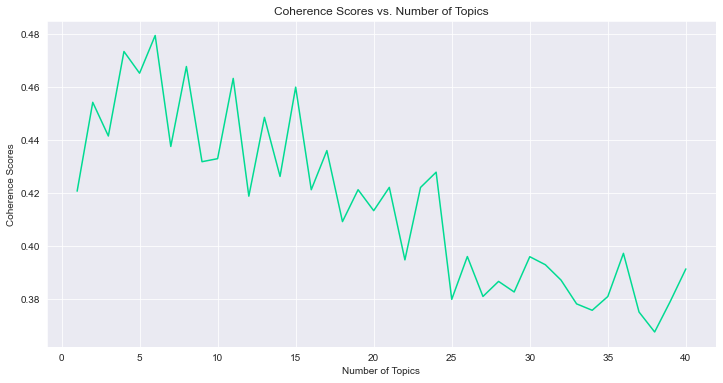

num_topics  coherence_score
5            6         0.479609
3            4         0.473553
7            8         0.467871
4            5         0.465331
10          11         0.463368
14          15         0.460069
1            2         0.454332
12          13         0.448640
2            3         0.441591
6            7         0.437641
16          17         0.436070
9           10         0.433016
8            9         0.431869
23          24         0.427906
13          14         0.426304
20          21         0.422159
22          23         0.422133
18          19         0.421283
15          16         0.421274
0            1         0.420716
11          12         0.418831
19          20         0.413353
17          18         0.409216
35          36         0.397221
25          26         0.396012
29          30         0.395945
21          22         0.394747
30          31         0.392905
39          40         0.391334
31          32         0.387112
27          28         0.386609
28          29         0.382609
26          27         0.380913
34          35         0.380896
24          25         0.379824
38          39         0.379035
32          33         0.378108
33          34         0.375685
36          37         0.375031
37          38         0.367482

In [362]:
# Load from pickle 
coherence_pros_df = find_optimal_topics(doc_term_matrix_pros, id2word_pros, lst_pros_final, min_topics=1, max_topics=40, display=True)
coherence_pros_df

# with open('coherence_pros_df.pickle', 'wb') as f:
#     pickle.dump(coherence_pros_df, f)

In [366]:
# Take the number of topics from above and create a model to print topics 
lda_model_pros = LdaModel(corpus=doc_term_matrix_pros, id2word=id2word_pros, num_topics=6, random_state=123, passes=25)
lda_model_pros.print_topics()

[(0,
  '0.047*"good" + 0.019*"benefit" + 0.013*"bonus" + 0.011*"free" + 0.010*"compensation" + 0.009*"decent" + 0.008*"hour" + 0.008*"time" + 0.008*"place work" + 0.008*"pretty"'),
 (1,
  '0.015*"firm" + 0.010*"great" + 0.010*"team" + 0.009*"business" + 0.008*"employee" + 0.008*"management" + 0.007*"technology" + 0.007*"industry" + 0.007*"company" + 0.006*"culture"'),
 (2,
  '0.038*"work" + 0.020*"great" + 0.015*"people" + 0.015*"culture" + 0.013*"great place" + 0.012*"opportunity" + 0.012*"get" + 0.012*"best" + 0.010*"employee" + 0.008*"team"'),
 (3,
  '0.032*"company" + 0.021*"work" + 0.021*"people" + 0.012*"employee" + 0.011*"really" + 0.009*"always" + 0.008*"place" + 0.008*"firm" + 0.007*"opportunity" + 0.007*"team"'),
 (4,
  '0.049*"learn" + 0.024*"nice people" + 0.009*"money" + 0.008*"time" + 0.007*"everything" + 0.007*"smart people" + 0.007*"super" + 0.007*"gym" + 0.006*"chance" + 0.006*"environment"'),
 (5,
  '0.091*"great" + 0.079*"good" + 0.052*"people" + 0.036*"benefit" + 0.

In [367]:
lda_model_pros_9 = LdaModel(corpus=doc_term_matrix_pros, id2word=id2word_pros, num_topics=8, random_state=123, passes=25)
lda_model_pros_9.print_topics()

[(0,
  '0.178*"good" + 0.051*"benefit" + 0.025*"compensation" + 0.018*"bonus" + 0.018*"company" + 0.017*"work" + 0.015*"people" + 0.014*"pay" + 0.011*"nice" + 0.010*"management"'),
 (1,
  '0.027*"firm" + 0.015*"business" + 0.014*"exposure" + 0.012*"technology" + 0.011*"team" + 0.010*"job" + 0.009*"best" + 0.009*"company" + 0.009*"product" + 0.009*"strong"'),
 (2,
  '0.028*"employee" + 0.020*"work life balance" + 0.016*"firm" + 0.013*"culture" + 0.013*"industry" + 0.012*"opportunity" + 0.011*"company" + 0.009*"work" + 0.008*"level" + 0.006*"support"'),
 (3,
  '0.032*"company" + 0.013*"opportunity" + 0.011*"work" + 0.010*"team" + 0.008*"way" + 0.008*"always" + 0.008*"feel" + 0.008*"employee" + 0.007*"many" + 0.007*"open"'),
 (4,
  '0.055*"learn" + 0.021*"interesting work" + 0.017*"smart people" + 0.014*"high" + 0.013*"money" + 0.012*"comp" + 0.011*"environment" + 0.008*"resource" + 0.007*"relatively" + 0.007*"stable"'),
 (5,
  '0.068*"great" + 0.034*"people" + 0.034*"benefit" + 0.034*"go

In [368]:
lda_model_pros_11 = LdaModel(corpus=doc_term_matrix_pros, id2word=id2word_pros, num_topics=11, random_state=123, passes=25)
lda_model_pros_11.print_topics()

[(0,
  '0.051*"good" + 0.032*"bonus" + 0.016*"benefit" + 0.014*"place work" + 0.012*"name" + 0.012*"paid" + 0.011*"generous" + 0.011*"package" + 0.010*"competitive" + 0.009*"compensation"'),
 (1,
  '0.041*"firm" + 0.016*"exposure" + 0.016*"strong" + 0.014*"industry" + 0.014*"product" + 0.012*"investment" + 0.012*"business" + 0.011*"focused" + 0.010*"culture" + 0.009*"team"'),
 (2,
  '0.021*"best" + 0.021*"work" + 0.020*"employee" + 0.015*"team" + 0.011*"get" + 0.010*"level" + 0.009*"opportunity" + 0.008*"everyone" + 0.008*"firm" + 0.008*"manager"'),
 (3,
  '0.053*"company" + 0.019*"employee" + 0.016*"growth" + 0.015*"opportunity" + 0.014*"support" + 0.012*"big" + 0.008*"compared" + 0.008*"daily" + 0.007*"diverse" + 0.007*"global"'),
 (4,
  '0.085*"learn" + 0.024*"interesting work" + 0.022*"people" + 0.022*"smart people" + 0.013*"open" + 0.011*"creative" + 0.010*"name resume" + 0.010*"intelligent" + 0.010*"quality" + 0.009*"ambitious"'),
 (5,
  '0.057*"great" + 0.036*"people" + 0.026*"p

**Interpretation:**

* Scores stay high through ~15 topics, and then dip off. 
* After looking at a few numbers of topics, pptimal number of topics chosen is 12. Interpretation might be different from a different assessor. 

pyLDAvis visualization

In [320]:
# Visualize lda model 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_pros, doc_term_matrix_pros, id2word_pros)
vis 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.036482 -0.047151       1        1  34.234831
1      0.228265 -0.006723       2        1  21.768067
0      0.202951  0.040765       3        1  11.097260
3     -0.126559 -0.075912       4        1   9.584915
6     -0.152502 -0.211567       5        1   9.456492
2      0.095134  0.042609       6        1   7.613633
4     -0.210807  0.257980       7        1   6.244802, topic_info=           Term         Freq        Total Category  logprob  loglift
17        great  2858.000000  2858.000000  Default  30.0000  30.0000
1          good  2379.000000  2379.000000  Default  29.0000  29.0000
5       benefit  1296.000000  1296.000000  Default  28.0000  28.0000
18       people  2047.000000  2047.000000  Default  27.0000  27.0000
24         nice   604.000000   604.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
300  leadership    36.482113   146.699237   Topic7  -5.0094   1.3819
312     growing    31.691864    99.939447   Topic7  -5.1502   1.6249
199      across    30.753985    88.826298   Topic7  -5.1802   1.7128
219         one    33.862907   166.387308   Topic7  -5.0839   1.1814
18       people    46.181967  2047.098326   Topic7  -4.7737  -1.0182

[459 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
423       5  0.984048  absolutely
199       1  0.641702      across
199       7  0.348996      across
1597      2  0.968063    addition
854       4  0.940177  additional
...     ...       ...         ...
57        1  0.663440        year
57        4  0.087295        year
57        5  0.250245        year
623       1  0.426487       young
623       3  0.573091       young

[699 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 1, 4, 7, 3, 5])

Wordcloud Visualization

Total plots: 6, Total cols: 4, Total rows: 2


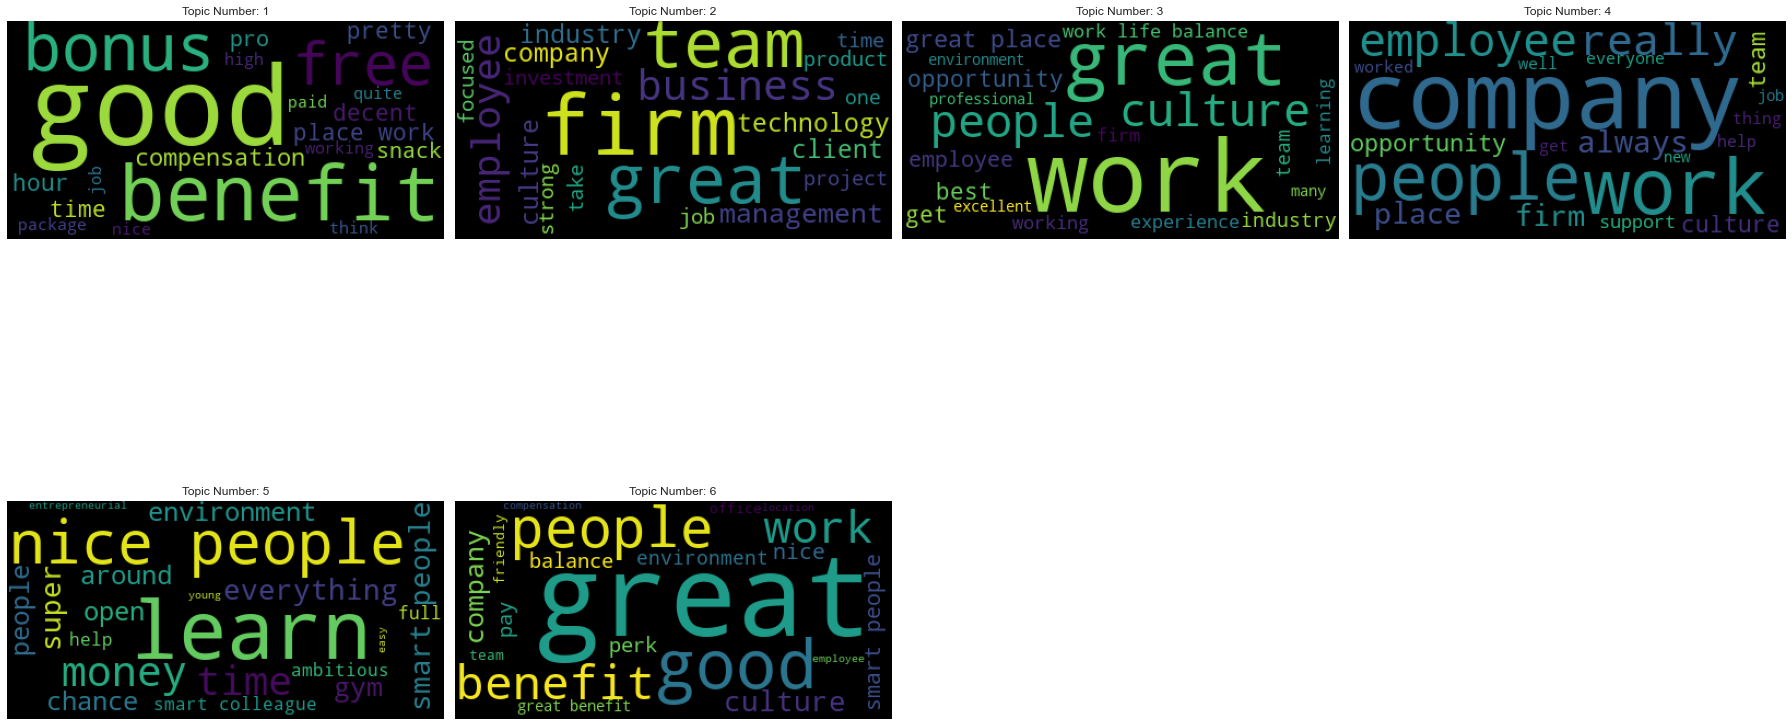

In [369]:
plot_wordclouds_lda(lda_model_pros)

Total plots: 8, Total cols: 4, Total rows: 2


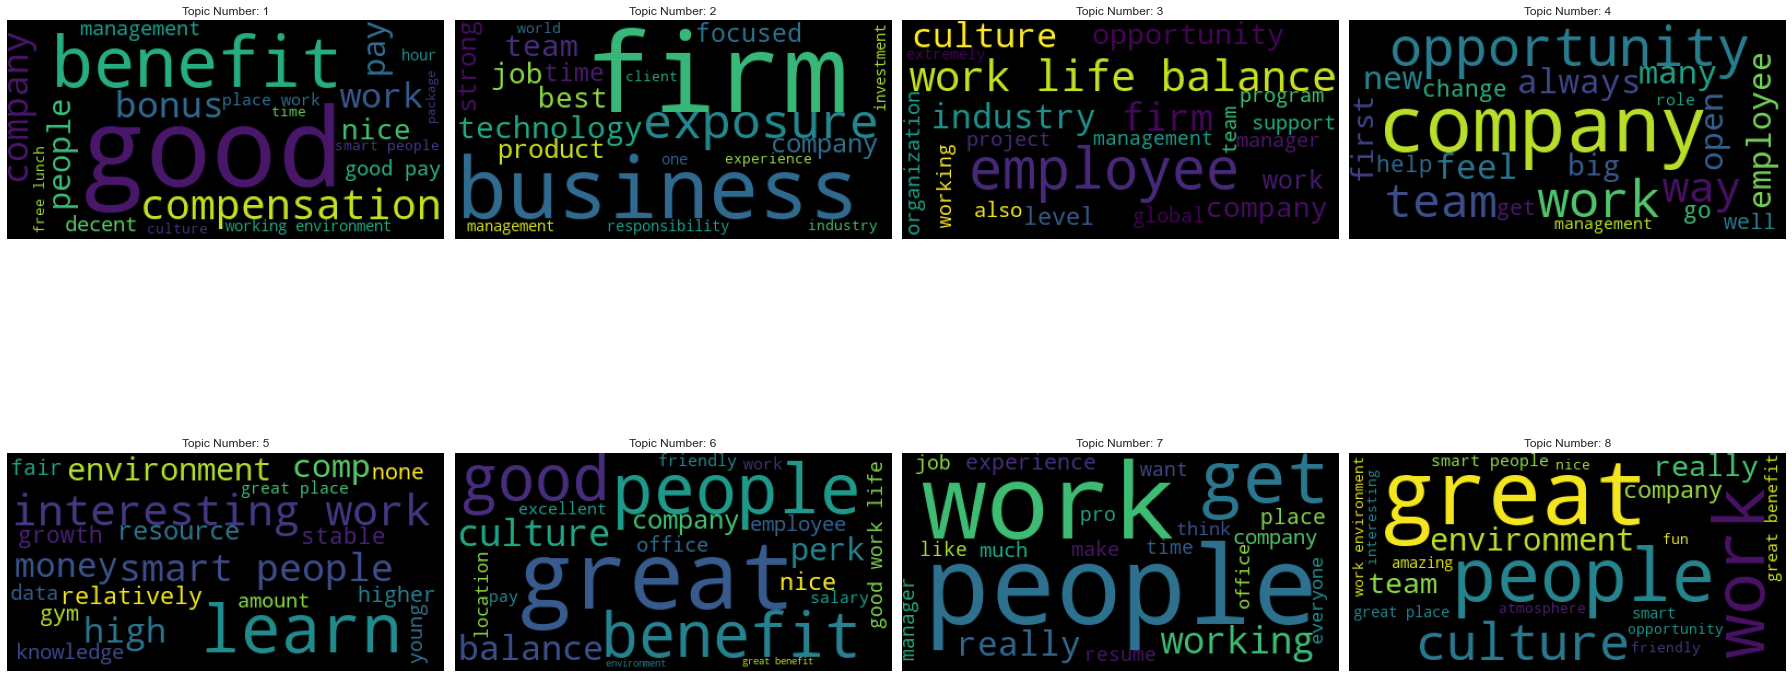

In [370]:
plot_wordclouds_lda(lda_model_pros_9)

Total plots: 11, Total cols: 4, Total rows: 3


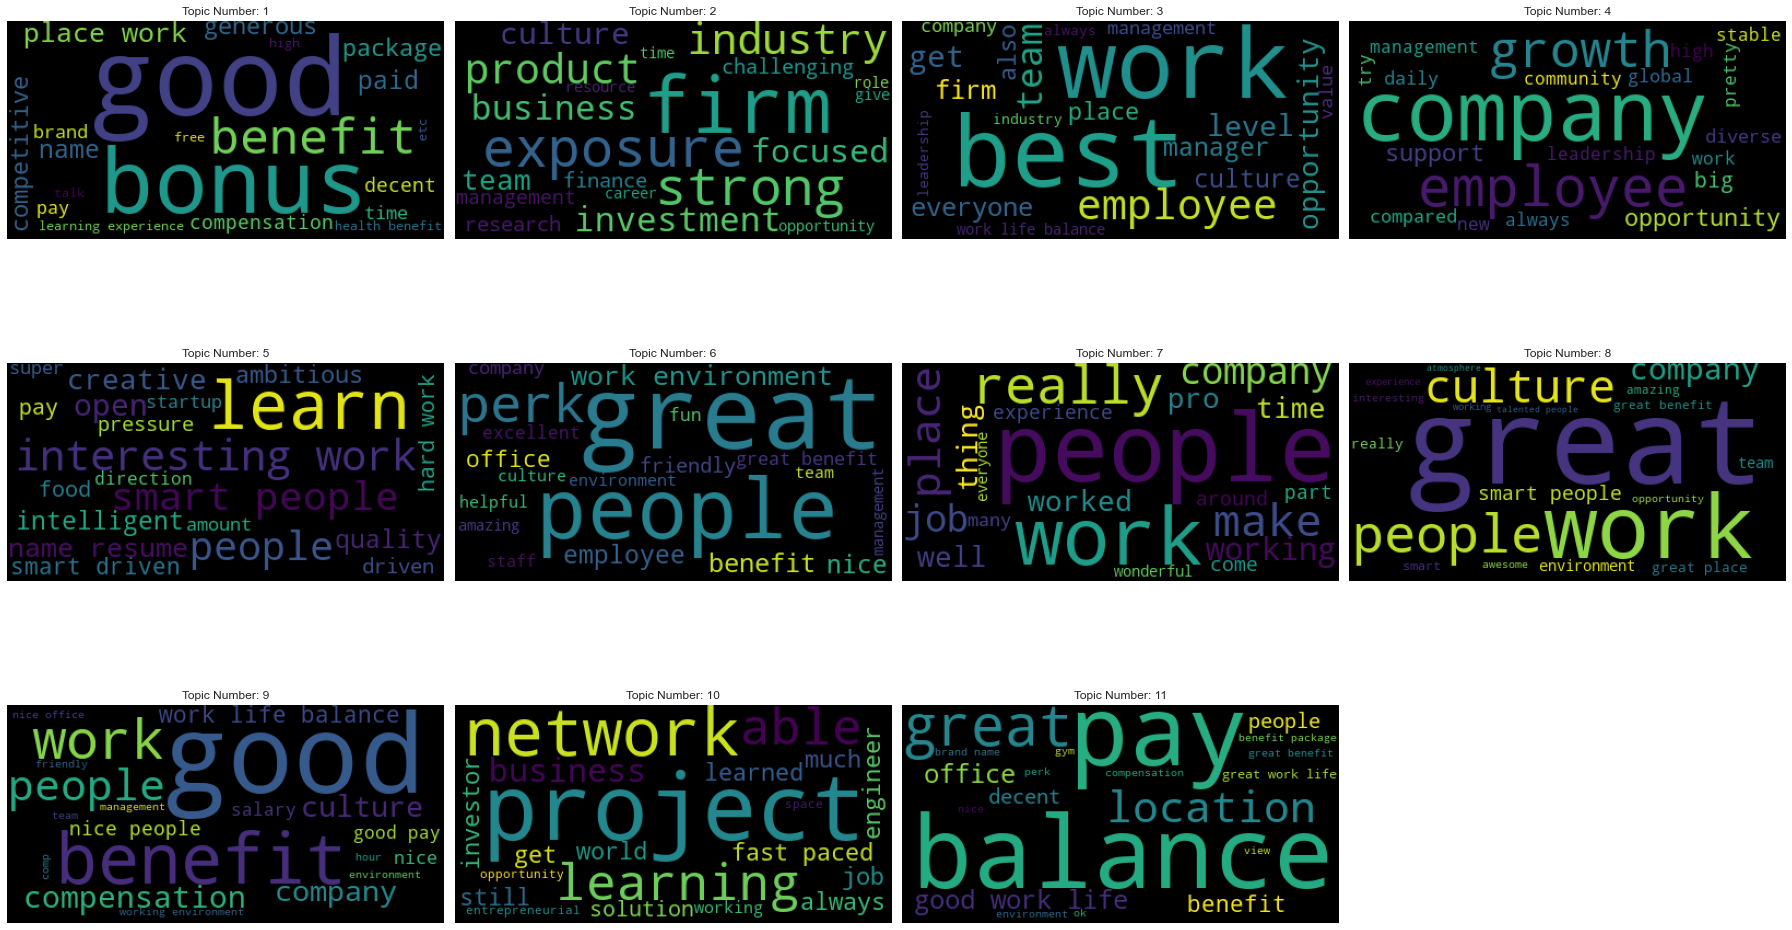

In [371]:
plot_wordclouds_lda(lda_model_pros_12)

#### Interpretation:
* Topic 1 is about pay and bonuses (1 = package)
* Topic 11 is about office and location 
* Topic 4 is about growth opportunity 
* Topic 3, 6 and 8 are  about people and culture (3 about management and team, 6 = more about office and 8 = types of people)
* Topic 5 and 10 are  about learning and development  
* Topic 2 is about the business, product 

#### 3B. Pandemic

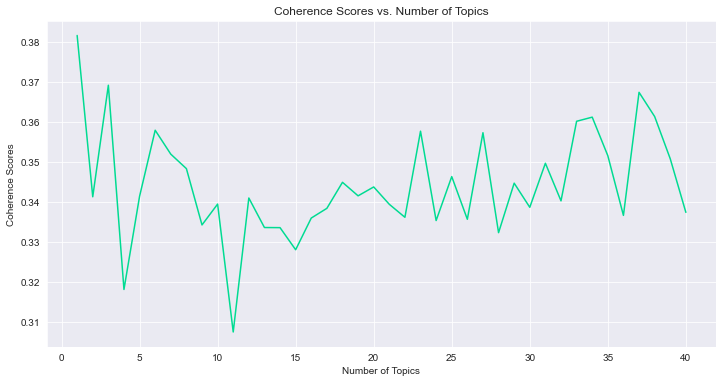

num_topics  coherence_score
0            1         0.381729
2            3         0.369253
36          37         0.367478
37          38         0.361407
33          34         0.361256
32          33         0.360219
5            6         0.357974
22          23         0.357738
26          27         0.357356
6            7         0.351981
34          35         0.351589
38          39         0.350814
30          31         0.349698
7            8         0.348351
24          25         0.346353
17          18         0.344925
28          29         0.344708
19          20         0.343762
18          19         0.341533
4            5         0.341416
1            2         0.341294
11          12         0.340989
31          32         0.340276
9           10         0.339463
20          21         0.339411
29          30         0.338657
16          17         0.338399
39          40         0.337389
35          36         0.336630
21          22         0.336153
15          16         0.335964
25          26         0.335656
23          24         0.335339
8            9         0.334240
12          13         0.333589
13          14         0.333559
27          28         0.332302
14          15         0.328020
3            4         0.318065
10          11         0.307409

In [372]:
# Load from pickle 
id2word_pandemic, doc_term_matrix_pandemic = get_id2word_doc_matrix(lst_pros_final_pandemic)
coherence_pros_df_pandemic = find_optimal_topics(doc_term_matrix_pandemic, id2word_pandemic, 
                                                 lst_pros_final_pandemic, min_topics=1, max_topics=40, display=True)
coherence_pros_df_pandemic

# with open('coherence_pros_df.pickle', 'wb') as f:
#     pickle.dump(coherence_pros_df, f)

**Interpretation:**
* Optimal number of topics is 7. Relatively high coherence score and keeps topic number consistent with topic model using all reviews

In [373]:
# Take the number of topics from above and create a model to print topics 
lda_model_pandemic = LdaModel(corpus=doc_term_matrix_pandemic, id2word=id2word_pandemic, 
                              num_topics=7, random_state=123, passes=25)
lda_model_pandemic.print_topics()

[(0,
  '0.026*"balance" + 0.023*"good work life" + 0.023*"good" + 0.020*"firm" + 0.018*"benefit" + 0.018*"decent" + 0.015*"work" + 0.015*"hour" + 0.012*"office" + 0.010*"time"'),
 (1,
  '0.015*"well" + 0.015*"company" + 0.014*"great" + 0.013*"solid" + 0.012*"benefit" + 0.011*"culture" + 0.010*"really" + 0.009*"employee" + 0.008*"lunch" + 0.008*"make"'),
 (2,
  '0.103*"great" + 0.046*"work" + 0.024*"people" + 0.024*"company" + 0.022*"team" + 0.021*"learn" + 0.018*"culture" + 0.017*"smart people" + 0.017*"opportunity" + 0.015*"exposure"'),
 (3,
  '0.012*"business" + 0.010*"employee" + 0.010*"work" + 0.010*"company" + 0.009*"support" + 0.009*"flexible" + 0.008*"product" + 0.008*"team" + 0.008*"industry" + 0.007*"looking"'),
 (4,
  '0.031*"people" + 0.025*"environment" + 0.017*"great" + 0.016*"smart" + 0.015*"interesting work" + 0.014*"friendly" + 0.013*"staff" + 0.013*"good" + 0.011*"work environment" + 0.010*"high"'),
 (5,
  '0.052*"people" + 0.045*"good" + 0.028*"nice" + 0.024*"work" + 

pyLDAvis visualization

In [196]:
# Visualize lda model 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_pandemic, doc_term_matrix_pandemic, id2word_pandemic)
vis 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.113448  0.106865       1        1  22.363826
1      0.034016  0.123598       2        1  19.925089
3     -0.213201  0.001234       3        1  15.651021
0      0.153555 -0.090237       4        1  14.438817
4     -0.084632 -0.147485       5        1  10.541147
5      0.155105  0.105707       6        1   9.398849
6      0.068605 -0.099683       7        1   7.681251, topic_info=                  Term         Freq        Total Category  logprob  loglift
1                 good  1067.000000  1067.000000  Default  30.0000  30.0000
48                 pay   267.000000   267.000000  Default  29.0000  29.0000
6              benefit   466.000000   466.000000  Default  28.0000  28.0000
18                work   823.000000   823.000000  Default  27.0000  27.0000
19               great  1019.000000  1019.000000  Default  26.0000  26.0000
..                 ...          ...          ...      ...      ...      ...
91          investment    12.919015    69.918913   Topic7  -5.1767   0.8778
305               make    11.887135    59.068860   Topic7  -5.2599   0.9631
69            employee    13.613854   231.371815   Topic7  -5.1243  -0.2666
394  work life balance    11.290032   128.284887   Topic7  -5.3115   0.1361
82        smart people    11.220458   177.939341   Topic7  -5.3177  -0.1973

[483 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
296       1  0.283618   ability
296       6  0.526719   ability
296       7  0.162067   ability
1309      1  0.199603      able
1309      2  0.119762      able
...     ...       ...       ...
62        4  0.237163      year
62        6  0.059291      year
302       4  0.077311  year end
302       5  0.927736  year end
1272      1  0.890526     young

[812 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1, 5, 6, 7])

WordCloud visualization

In [ ]:
plot_wordclouds_lda(lda_model_pandemic)

### 4. GSDMM Modeling

How it works link[https://towardsdatascience.com/short-text-topic-modelling-lda-vs-gsdmm-20f1db742e14]

While LDA performs very well on larger texts (>50 words or so), its performance tends to nose-dive when trying to model the topics of shorter texts, for the pretty obvious reason that a short text (such as a Tweet or the title of a forum question) is likely to refer to only a single topic.

#### Example:
“Imagine a bunch of students in a restaurant, seating randomly at K tables. They are all asked to write their favorite movies on a paper (but it must remain a short list). The objective is to cluster them in such a way that so students within the same group share the same movie interest. To do so, one after another, students must make a new table choice regarding the two following rules:
* Rule 1: Choose a table with more students. This rule improves completeness, all students sharing the same movie’s interest are assigned to the same table.
* Rule 2: Choose a table where students share similar movie’s interest. This rule aims to increase homogeneity, we want only members sharing the same movie’s interest at a table.

After repeating this process, we expect some tables to disappear and others to grow larger and eventually have clusters of students matching their movie’s interest. This is simply what the GSDMM algorithm does!”

https://github.com/rwalk/gsdmm

### 4A. All words

In [264]:
# Note that GSDMM only requires two input variables: the documents as a numpy array and the length of your dictionary/vocabulary.

# initialize GSDMM
gsdmm = MovieGroupProcess(K=15, alpha=0.1, beta=0.3, n_iters=50)
vocab_len = len(id2word_pros)
# fit GSDMM model
y = gsdmm.fit(lst_pros_final, vocab_len) #total_word_count = len(tokens)

In stage 0: transferred 7481 clusters with 15 clusters populated
In stage 1: transferred 5871 clusters with 15 clusters populated
In stage 2: transferred 3809 clusters with 15 clusters populated
In stage 3: transferred 2621 clusters with 15 clusters populated
In stage 4: transferred 2165 clusters with 13 clusters populated
In stage 5: transferred 1904 clusters with 13 clusters populated
In stage 6: transferred 1758 clusters with 12 clusters populated
In stage 7: transferred 1649 clusters with 11 clusters populated
In stage 8: transferred 1623 clusters with 11 clusters populated
In stage 9: transferred 1593 clusters with 11 clusters populated
In stage 10: transferred 1500 clusters with 10 clusters populated
In stage 11: transferred 1547 clusters with 9 clusters populated
In stage 12: transferred 1522 clusters with 9 clusters populated
In stage 13: transferred 1475 clusters with 9 clusters populated
In stage 14: transferred 1505 clusters with 10 clusters populated
In stage 15: transferre

In [273]:
# number of docs per topic 
doc_count = np.array(gsdmm.cluster_doc_count)
# print('Number of documents per topic :', doc_count)

# sort the indexes by importance 
indexes_sorted = doc_count.argsort()[::-1]
print(f'Index of docs arranged by importance: {indexes_sorted}')
"""This will generate a list of the total number of clusters, 
with the top {num_words} most-recurring words, and the number of times each of those top {num_words} words occurs in the topic."""
top_words_gsdmm(gsdmm.cluster_word_distribution, indexes_sorted, 20)

Index of docs arranged by importance: [ 8  0 14  1  7 11 10  6  4 13 12  9  5  3  2]
Cluster 8: [('great', 1986), ('good', 1935), ('people', 1271), ('work', 1109), ('benefit', 1046), ('culture', 625), ('company', 533), ('environment', 490), ('nice', 483), ('pay', 469), ('smart people', 332), ('balance', 260), ('friendly', 245), ('team', 240), ('compensation', 232), ('opportunity', 206), ('employee', 192), ('management', 188), ('salary', 185), ('location', 180)]
Cluster 0: [('great', 486), ('work', 359), ('good', 313), ('people', 281), ('culture', 273), ('company', 225), ('firm', 212), ('opportunity', 197), ('team', 178), ('environment', 150), ('business', 137), ('employee', 136), ('get', 129), ('strong', 123), ('industry', 116), ('management', 109), ('exposure', 108), ('smart people', 103), ('learn', 102), ('investment', 102)]
Cluster 14: [('people', 587), ('work', 560), ('company', 473), ('great', 400), ('employee', 328), ('culture', 294), ('team', 278), ('good', 225), ('opportunity',

In [266]:
# gsdmm.cluster_word_distribution[10].items()

Total plots: 10, Total cols: 4, Total rows: 3


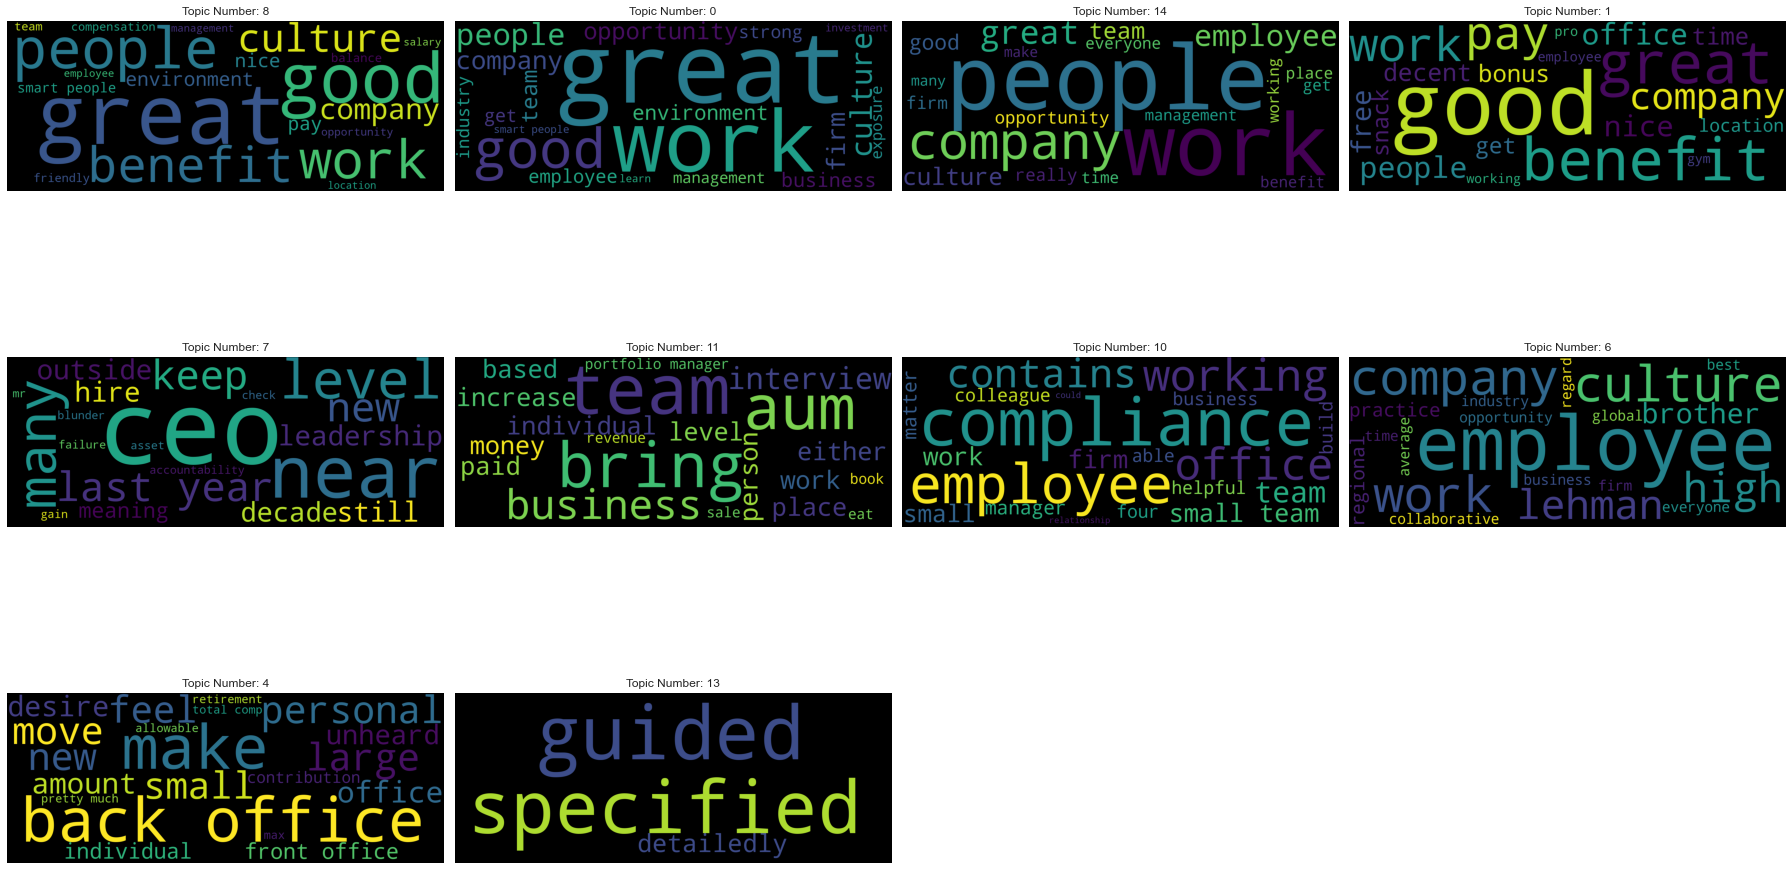

In [267]:
plot_wordclouds(gsdmm.cluster_word_distribution, indexes_sorted)

### 4B. Pandemic

In [140]:
# Note that GSDMM only requires two input variables: the documents as a numpy array and the length of your dictionary/vocabulary.

# initialize GSDMM
gsdmm = MovieGroupProcess(K=15, alpha=0.1, beta=0.3, n_iters=50)
vocab_len = len(id2word_pandemic)
# fit GSDMM model
y = gsdmm.fit(lst_pros_final_pandemic, vocab_len) #total_word_count = len(tokens)

In stage 0: transferred 3761 clusters with 15 clusters populated
In stage 1: transferred 2855 clusters with 15 clusters populated
In stage 2: transferred 1961 clusters with 15 clusters populated
In stage 3: transferred 1377 clusters with 15 clusters populated
In stage 4: transferred 1063 clusters with 15 clusters populated
In stage 5: transferred 861 clusters with 15 clusters populated
In stage 6: transferred 786 clusters with 14 clusters populated
In stage 7: transferred 717 clusters with 13 clusters populated
In stage 8: transferred 710 clusters with 12 clusters populated
In stage 9: transferred 680 clusters with 13 clusters populated
In stage 10: transferred 648 clusters with 12 clusters populated
In stage 11: transferred 624 clusters with 12 clusters populated
In stage 12: transferred 590 clusters with 12 clusters populated
In stage 13: transferred 581 clusters with 12 clusters populated
In stage 14: transferred 582 clusters with 11 clusters populated
In stage 15: transferred 614 c

In [141]:
# number of docs per topic 
doc_count = np.array(gsdmm.cluster_doc_count)
# print('Number of documents per topic :', doc_count)

# sort the indexes by importance 
indexes_sorted = doc_count.argsort()[::-1]
# print(f'Index of docs arranged by importance: {indexes_sorted}')

top_words_gsdmm(gsdmm.cluster_word_distribution, indexes_sorted, 20)

Cluster 7: [('good', 1297), ('great', 1086), ('work', 694), ('people', 628), ('benefit', 507), ('culture', 465), ('pay', 292), ('company', 277), ('environment', 245), ('nice', 241), ('work life balance', 210), ('smart people', 194), ('team', 193), ('place', 187), ('compensation', 149), ('friendly', 143), ('opportunity', 134), ('salary', 112), ('management', 110), ('firm', 105)]
Cluster 6: [('work', 251), ('people', 234), ('great', 225), ('company', 205), ('culture', 204), ('good', 171), ('employee', 152), ('team', 106), ('firm', 98), ('get', 96), ('opportunity', 83), ('benefit', 73), ('environment', 73), ('really', 67), ('well', 66), ('best', 63), ('management', 62), ('place', 61), ('learn', 60), ('strong', 57)]
Cluster 14: [('work', 65), ('team', 48), ('people', 46), ('firm', 45), ('company', 45), ('place', 36), ('employee', 35), ('good', 32), ('time', 31), ('one', 29), ('like', 29), ('great', 28), ('get', 28), ('office', 28), ('benefit', 24), ('year', 24), ('new', 24), ('many', 23), 

In [142]:
# gsdmm.cluster_word_distribution[10].items()

Total plots: 9, Total cols: 4, Total rows: 3


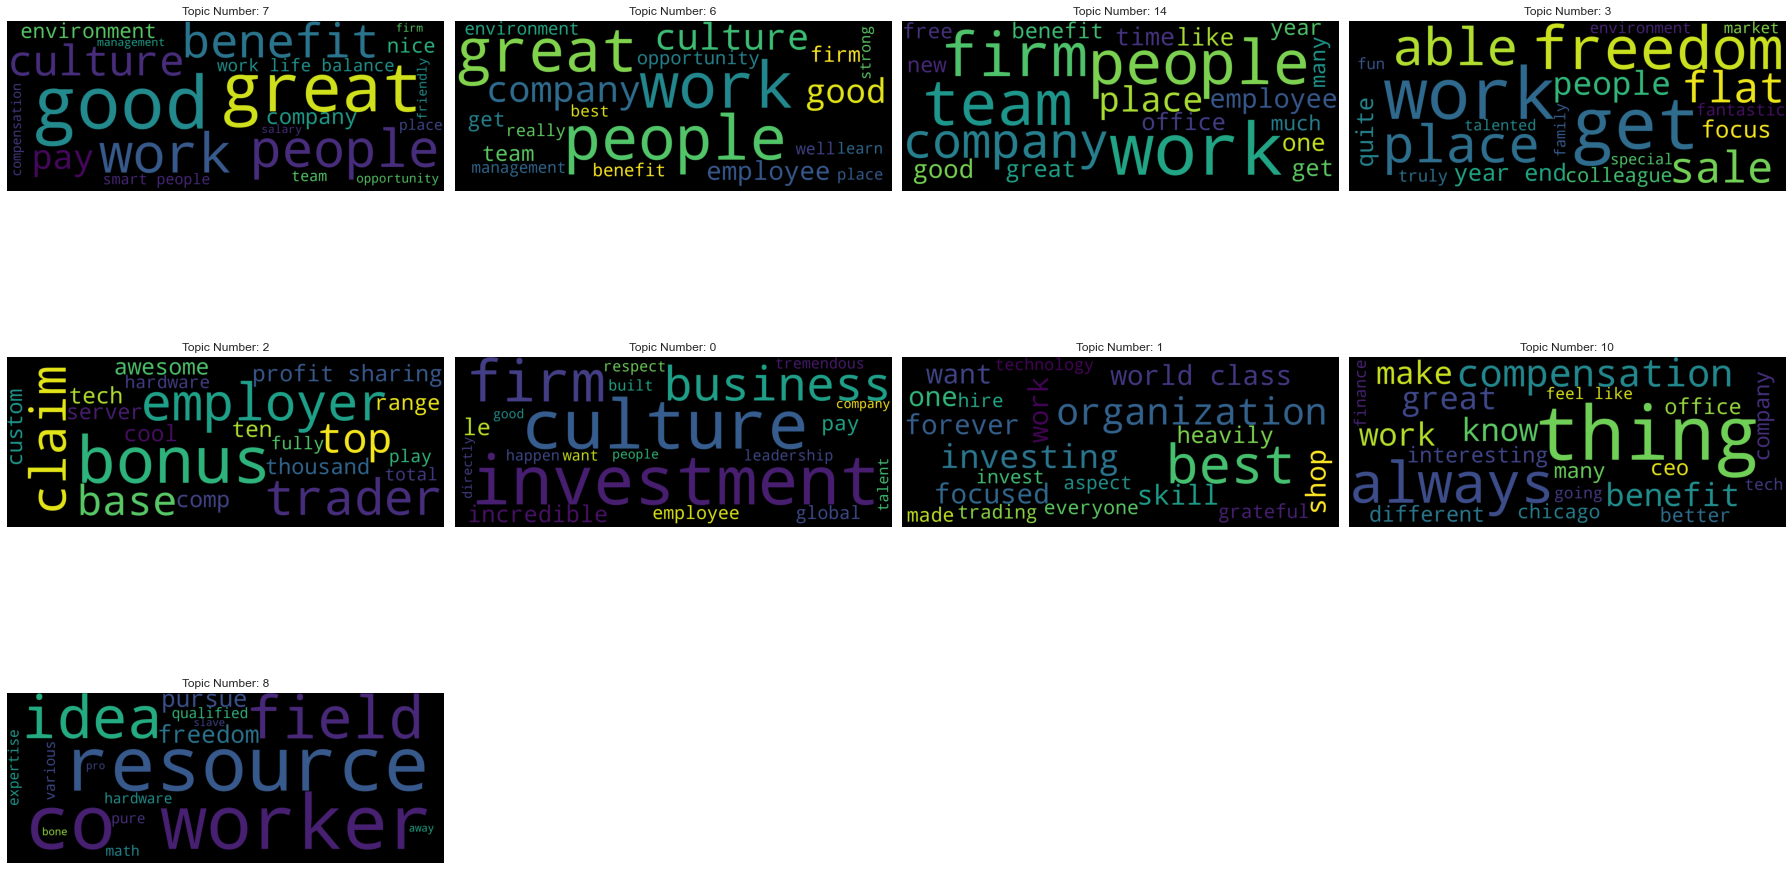

In [143]:
plot_wordclouds(gsdmm.cluster_word_distribution, indexes_sorted)

## Analyzing Cons Column
1. Most common words 
2. Bigrams and trigrams 
3. LDA 
4. GSDMM 

In [254]:
lst_corpus_cons = df['cons_cleaned'].map(word_tokenize).values
lst_corpus_cons_pandemic = df_pandemic['cons_cleaned'].map(word_tokenize).values
tokens_cons = list(itertools.chain(*lst_corpus_cons))
tokens_cons_pandemic = list(itertools.chain(*lst_corpus_cons_pandemic))

### 1. Most Common Words

In [244]:
# 1A. All reviews

freqdist = FreqDist(tokens_cons)
print(most_common_words(tokens_cons, 25, display=True))

# 1B. Pandemic
freqdist = FreqDist(tokens_cons_pandemic)
print(most_common_words(tokens_cons_pandemic, 25, display=True))

There are 8839 words in the vocabulary of corpus, after stopwords have been removed.

Normalized Frequency

work: 0.019603507996167734
management: 0.01251218054224908
people: 0.011570491561647874
company: 0.00992458299555359
hour: 0.008532521024230067
culture: 0.00813127963249564
time: 0.00809852523317038
employee: 0.0076235864429541195
long: 0.007255099450544951
team: 0.007214156451388377
get: 0.006845669458979209
firm: 0.005863037479221428
manager: 0.005388098689005167
life: 0.005388098689005167
like: 0.005093309095077833
much: 0.005019611696595999
year: 0.0047166335028373495
job: 0.0046920677033434055
balance: 0.004544672906379738
many: 0.0045037299072231635
working: 0.004454598308235275
pay: 0.004430032508741331
office: 0.004397278109416071
good: 0.004258071912283719
growth: 0.00420894031329583
None
There are 4937 words in the vocabulary of corpus, after stopwords have been removed.

Normalized Frequency

work: 0.024150405054261987
hour: 0.012126152748764458
management: 0.011336424

### 2. Bigrams 

#### 2A. All reviews

In [138]:
display_bigrams(tokens_cons)

Top Bigrams Based on Raw Frequency: 
(('work', 'life'), 0.004389089509584756)
(('life', 'balance'), 0.004217128913127145)
(('long', 'hour'), 0.003996036717681644)
(('senior', 'management'), 0.0012446671743598563)
(('upper', 'management'), 0.0009253117809385773)
(('place', 'work'), 0.0009007459814446328)
(('work', 'environment'), 0.0008270485829627992)
(('high', 'turnover'), 0.0008024827834688547)
(('working', 'hour'), 0.0007615397843122805)
(('work', 'hour'), 0.0006714651861678172)

Top Bigrams Based on PMI: 
('kool', 'aid')
('sink', 'swim')
('tuition', 'reimbursement')
('inner', 'circle')
('red', 'tape')
('jersey', 'city')
('frowned', 'upon')
('class', 'citizen')
('sub', 'par')
('health', 'insurance')


#### 2B. Pandemic

In [139]:
display_bigrams(tokens_cons_pandemic)

Top Bigrams Based on Raw Frequency: 
(('work', 'life'), 0.006164976817649157)
(('life', 'balance'), 0.005910225709481836)
(('long', 'hour'), 0.005910225709481836)
(('working', 'hour'), 0.0015794568706373872)
(('place', 'work'), 0.0010954297651194782)
(('upper', 'management'), 0.0010699546543027462)
(('senior', 'management'), 0.00099352932185255)
(('none', 'think'), 0.000968054211035818)
(('none', 'none'), 0.0008916288785856219)
(('work', 'environment'), 0.0008916288785856219)

Top Bigrams Based on PMI: 
('boy', 'club')
('cut', 'throat')
('co', 'worker')
('growing', 'pain')
('white', 'male')
('word', 'word')
('non', 'existent')
('upward', 'mobility')
('fast', 'paced')
('old', 'school')


### 3. LDA 

In [255]:
lst_cons_final = get_bigrams_trigrams(lst_corpus_cons)
lst_cons_final_pandemic = get_bigrams_trigrams(lst_corpus_cons_pandemic)
# print(len(lst_cons_final), len(lst_corpus_cons))

#### 3A. All reviews

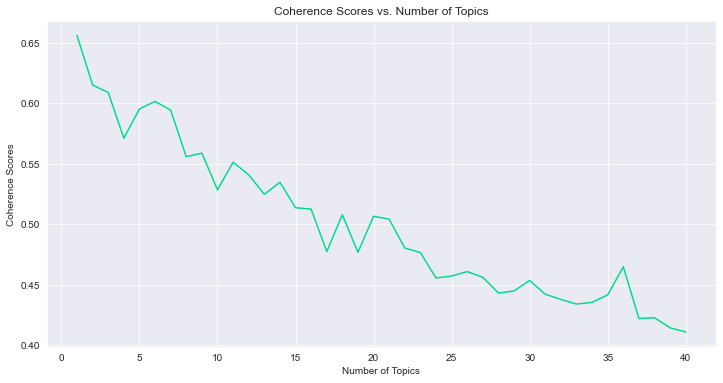

num_topics  coherence_score
0            1         0.655853
1            2         0.614925
2            3         0.608738
5            6         0.601378
4            5         0.595126
6            7         0.594163
3            4         0.570966
8            9         0.558604
7            8         0.555719
10          11         0.551133
11          12         0.540746
13          14         0.534610
9           10         0.528371
12          13         0.524604
14          15         0.513552
15          16         0.512387
17          18         0.507699
19          20         0.506485
20          21         0.504112
21          22         0.480267
16          17         0.477407
18          19         0.476669
22          23         0.476479
35          36         0.464753
25          26         0.460801
24          25         0.457172
26          27         0.456089
23          24         0.455477
29          30         0.453444
28          29         0.444856
27          28         0.443033
30          31         0.442100
34          35         0.441571
31          32         0.437815
33          34         0.435414
32          33         0.433967
37          38         0.422671
36          37         0.422056
38          39         0.414330
39          40         0.410913

In [256]:
# Load from pickle 
id2word_cons, doc_term_matrix_cons = get_id2word_doc_matrix(lst_cons_final)
coherence_pros_df = find_optimal_topics(doc_term_matrix_cons, id2word_cons, lst_cons_final, min_topics=1, max_topics=40, display=True)
coherence_pros_df

# with open('coherence_pros_df.pickle', 'wb') as f:
#     pickle.dump(coherence_pros_df, f)

**Interpretation:**
* Is the optimal number of topics chosen. Used the same number of topics as I did for pros to keep things consistent. 

In [201]:
# Take the number of topics from above and create a model to print topics 
lda_model_cons = LdaModel(corpus=doc_term_matrix, id2word=id2word, num_topics=7, random_state=123, passes=25)
lda_model_cons.print_topics()

[(0,
  '0.028*"people" + 0.017*"work" + 0.011*"team" + 0.010*"get" + 0.010*"one" + 0.008*"job" + 0.008*"management" + 0.008*"make" + 0.007*"like" + 0.007*"place"'),
 (1,
  '0.017*"work" + 0.013*"time" + 0.013*"sometimes" + 0.010*"culture" + 0.010*"job" + 0.009*"environment" + 0.009*"process" + 0.008*"right" + 0.008*"pressure" + 0.007*"like"'),
 (2,
  '0.033*"company" + 0.016*"firm" + 0.013*"good" + 0.012*"people" + 0.012*"nothing" + 0.011*"management" + 0.011*"none" + 0.010*"great" + 0.008*"change" + 0.008*"manager"'),
 (3,
  '0.061*"long hour" + 0.040*"culture" + 0.021*"work" + 0.019*"bit" + 0.015*"environment" + 0.013*"work life balance" + 0.013*"time" + 0.012*"political" + 0.010*"none think" + 0.009*"good"'),
 (4,
  '0.017*"company" + 0.014*"employee" + 0.010*"lack" + 0.009*"pay" + 0.009*"team" + 0.009*"management" + 0.008*"low" + 0.007*"firm" + 0.006*"need" + 0.006*"business"'),
 (5,
  '0.023*"management" + 0.011*"company" + 0.009*"people" + 0.008*"group" + 0.008*"team" + 0.008*"co

pyLDAvis visualization

In [202]:
# Visualize lda model 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_cons, doc_term_matrix, id2word)
vis 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.038899  0.168517       1        1  28.835984
4      0.153727 -0.112701       2        1  17.127255
5      0.155413 -0.133274       3        1  13.527425
2      0.111732  0.089374       4        1  13.200015
6     -0.127954  0.051482       5        1  10.605922
1     -0.085460  0.077475       6        1  10.522214
3     -0.246358 -0.140873       7        1   6.181184, topic_info=          Term         Freq        Total Category  logprob  loglift
315  long hour   441.000000   441.000000  Default  30.0000  30.0000
270       work  1511.000000  1511.000000  Default  29.0000  29.0000
20     culture   765.000000   765.000000  Default  28.0000  28.0000
17     company  1139.000000  1139.000000  Default  27.0000  27.0000
292       hour   296.000000   296.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
307     little    39.510353   329.133506   Topic7  -5.1694   0.6638
291       hard    35.249351   290.723679   Topic7  -5.2835   0.6737
84       place    36.000080   407.670282   Topic7  -5.2624   0.3567
40        poor    32.176848   211.270773   Topic7  -5.3747   0.9018
79     working    30.331863   395.723928   Topic7  -5.4338   0.2151

[492 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1453      1  0.986655  accounting
3084      5  0.931616     achieve
2052      2  0.955706    activity
1714      6  0.978719         add
1407      3  0.986702       admin
...     ...       ...         ...
2010      4  0.974010       write
227       1  0.510555        year
227       2  0.115202        year
227       4  0.238259        year
227       6  0.133530        year

[825 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 6, 3, 7, 2, 4])

WordCloud visualization

In [ ]:
plot_wordclouds_lda(lda_model_cons)

#### Interpretation:
* Topic 1 is about pay
* Topic 11 is about learning and development 
* Topic 6 is about the office environment 

#### 3B. Pandemic

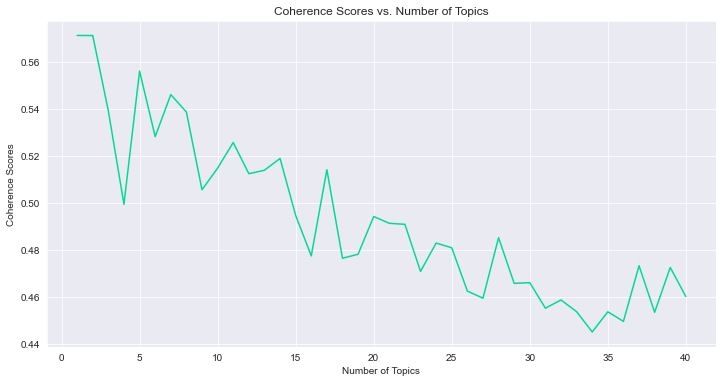

num_topics  coherence_score
0            1         0.571305
1            2         0.571277
4            5         0.556155
6            7         0.546137
2            3         0.539177
7            8         0.538713
5            6         0.528261
10          11         0.525758
13          14         0.518971
9           10         0.514836
16          17         0.514183
12          13         0.513955
11          12         0.512478
8            9         0.505660
3            4         0.499464
14          15         0.494737
19          20         0.494267
20          21         0.491381
21          22         0.490936
27          28         0.485247
23          24         0.482969
24          25         0.480960
18          19         0.478210
15          16         0.477513
17          18         0.476506
36          37         0.473321
38          39         0.472595
22          23         0.470911
29          30         0.466118
28          29         0.465822
25          26         0.462541
39          40         0.460209
26          27         0.459505
31          32         0.458747
30          31         0.455251
32          33         0.453773
34          35         0.453725
37          38         0.453510
35          36         0.449640
33          34         0.445129

In [204]:
# Load from pickle 
id2word_pandemic, doc_term_matrix_pandemic = get_id2word_doc_matrix(lst_cons_final_pandemic)
coherence_pros_df_pandemic = find_optimal_topics(doc_term_matrix_pandemic, id2word_pandemic, 
                                                 lst_cons_final_pandemic, min_topics=1, max_topics=40, display=True)
coherence_pros_df_pandemic

# with open('coherence_pros_df.pickle', 'wb') as f:
#     pickle.dump(coherence_pros_df, f)

**Interpretation:**
Optimal number of topics is 11. Scores rapidly go until score 6 and then level off through a higher number of topics. 

In [205]:
# Take the number of topics from above and create a model to print topics 
lda_model_pandemic_cons = LdaModel(corpus=doc_term_matrix_pandemic, id2word=id2word_pandemic, 
                              num_topics=7, random_state=123, passes=25)
lda_model_pandemic_cons.print_topics()

[(0,
  '0.051*"work" + 0.015*"work life balance" + 0.012*"management" + 0.011*"culture" + 0.011*"hour" + 0.011*"good" + 0.010*"environment" + 0.009*"office" + 0.009*"time" + 0.009*"great"'),
 (1,
  '0.040*"con" + 0.018*"none" + 0.014*"think" + 0.012*"time" + 0.012*"really" + 0.010*"bit" + 0.007*"job" + 0.007*"everything" + 0.007*"firm" + 0.007*"much"'),
 (2,
  '0.037*"long hour" + 0.015*"compensation" + 0.015*"time" + 0.013*"low" + 0.012*"pay" + 0.012*"team" + 0.012*"salary" + 0.011*"employee" + 0.010*"competitive" + 0.010*"industry"'),
 (3,
  '0.043*"company" + 0.010*"slow" + 0.009*"many" + 0.009*"much" + 0.008*"culture" + 0.007*"people" + 0.007*"working" + 0.007*"poor" + 0.007*"opportunity" + 0.006*"employee"'),
 (4,
  '0.017*"people" + 0.015*"company" + 0.013*"team" + 0.012*"management" + 0.010*"get" + 0.010*"firm" + 0.007*"job" + 0.007*"thing" + 0.006*"employee" + 0.006*"many"'),
 (5,
  '0.029*"work" + 0.022*"nothing" + 0.018*"hour" + 0.017*"hard" + 0.013*"much" + 0.013*"time" + 0.

pyLDAvis visualization

In [206]:
# Visualize lda model 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_pandemic_cons, doc_term_matrix_pandemic, id2word_pandemic)
vis 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.014677  0.050773       1        1  21.324052
4     -0.001958  0.007378       2        1  20.072293
0     -0.048048  0.124897       3        1  16.922335
2     -0.155997 -0.170950       4        1  10.913252
5     -0.000027  0.116609       5        1  10.677569
3      0.002057 -0.038034       6        1  10.179403
1      0.218650 -0.090672       7        1   9.911095, topic_info=          Term        Freq       Total Category  logprob  loglift
272       work  590.000000  590.000000  Default  30.0000  30.0000
17     company  319.000000  319.000000  Default  29.0000  29.0000
164        con  147.000000  147.000000  Default  28.0000  28.0000
303  long hour  192.000000  192.000000  Default  27.0000  27.0000
291       hour  139.000000  139.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
101     growth   15.334630   78.060049   Topic7  -5.4723   0.6842
327       lack   15.994774  110.195111   Topic7  -5.4302   0.3815
388       take   14.558093   75.018876   Topic7  -5.5243   0.6719
81     working   15.325398  153.856964   Topic7  -5.4729   0.0050
459    process   13.777350   98.078865   Topic7  -5.5794   0.3488

[518 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
322       1  0.162890  across
322       3  0.162890  across
322       4  0.244335  across
322       5  0.407225  across
937       5  0.969138   adapt
...     ...       ...     ...
229       5  0.075806    year
229       6  0.058960    year
229       7  0.168458    year
273       2  0.823470     yet
273       7  0.190032     yet

[995 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 1, 3, 6, 4, 2])

WordCloud visualization

In [ ]:
plot_wordclouds_lda(lda_model_pandemic_cons)

## Analyzing Headline Column
1. Most common words 
2. Bigrams and trigrams 
3. LDA 
4. GSDMM 

In [ ]:
lst_corpus_cons = df['cons_cleaned'].map(word_tokenize).values
lst_corpus_headlines = df['headline_cleaned'].map(word_tokenize).values
lst_corpus_combined = df['combined_text'].map(word_tokenize).values

# Predictions

## TF-IDF

In [195]:
df.head()

company                    headline       date  \
0  Allianz Global Investors                Great People 2022-04-21   
1  Allianz Global Investors               Great company 2022-04-11   
2  Allianz Global Investors             Working Student 2022-04-07   
3  Allianz Global Investors               Good employer 2022-04-05   
4  Allianz Global Investors  Mostly positive experience 2022-03-31   

   overall_rating                   author_position  \
0             5.0  Human Resources Business Partner   
1             5.0                   Working Student   
2             5.0                   Working Student   
3             5.0                IT Project Manager   
4             4.0                           Analyst   

                                                pros  \
0    People, benefits, management, team and culture.   
1  Good culture, interesting company, great colle...   
2          Good company, nice colleagues, good perks   
3  Flexible working \r\nNice colleagues\r\nNew te...   
4  Staff are generally approachable and collabora...   

                                                cons position_department  \
0                            I have no cons to share                  hr   
1                         not encountered any so far               other   
2          Nothing at the moment, everything is fine               other   
3  the management is not always aligned to the cu...          technology   
4  Internal decision making can be overly politic...          investment   

  position_level                                       pros_cleaned  \
0          other             people benefit management team culture   
1          other   good culture interesting company great colleague   
2          other              good company nice colleague good peak   
3          other  flexible working nice colleague new technology...   
4          other  staff generally unapproachable collaboration n...   

                                        cons_cleaned  \
0                                          son share   
1                                    encountered far   
2                     nothing moment everything fine   
3        management always signed current technology   
4  internal decision making overlay political thu...   

             headline_cleaned  \
0                great people   
1               great company   
2             working student   
3               good employer   
4  mostly positive experience   

                                       combined_text  
0  people benefit management team culture son sha...  
1  good culture interesting company great colleag...  
2  good company nice colleague good peak nothing ...  
3  flexible working nice colleague new technology...  
4  staff generally unapproachable collaboration n...

In [193]:
data = df['combined_text']
# data = lst_corpus_bigrams
target = df['overall_rating'].astype(int)

In [194]:
print(len(data))
print(len(lst_corpus_bigrams))
print(len(target))

11014
11014
11014


In [255]:
model = Pipeline([('vectorizer',TfidfVectorizer(ngram_range=(1,2), max_features=10000)),
                  ('classifier',MultinomialNB())])

In [256]:
cross_val_score(model, data, target, cv=5, error_score='raise') 

array([0.44130627, 0.42497793, 0.42144748, 0.43336275, 0.42541924])

## Word2Vec

In [17]:
# TODO create train test split with this 

corpus = df['combined_text']
lst_corpus = get_corpus_lst(corpus)

In [260]:
len(tokens)

320174

#### Definitions
* corpus: list of lists of n-grams
* padded sequence: every text (each list of n-grams) is now an id sequence with length X. For instance if length = 15, then if a text had 10 tokens in it, the sequence is composed of 10 ids + 5 0s, which is teh padding element. The id for word not in vocab is 1. 
* word embedding: vectors of words 

#### Process
1. Create or use a word embedding model to produce a vector space (usually several hundred dimensions) 
    * words that share common contexts in the corpsu are located close to one another in the space
2. Transform the corpus into padded sequences of word ids. Transform the corpus given to the word2vec into a list of sequences.
3. Create an embedding matrix so that the vector of the word with id N is located at the Nth row 
4. Build a neural network with an embedding layer that weighs every word in the sequences with the corresponding vector 

### Pre-trained GLOVE model 

In [285]:
with open('glove,pickle','rb') as f:
    glove = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'glove,pickle'

In [286]:
# compare out of the box to custom trained one 
glove = {}

with open('glove.6B.50d.txt','rb') as f:
    for line in f: 
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in tokens:
            vector = np.array(parts[1:],dtype=np.float32)
            glove[word] = vector 
            

NameError: name 'tokens' is not defined

In [263]:
with open('glove,pickle','wb') as f:
    pickle.dump(glove, f)

### Custom Word2Vec 
use the training data corpus with gensim 

In [43]:
total = 0
max_len = 0 
count = 0 
for txt in lst_corpus_bigrams:
    total += len(txt)
    if max_len < len(txt):
        max_len = len(txt)
    if len(txt) > 25: 
        count+=1

    
avg_len = int(total/len(lst_corpus_bigrams))

print(avg_len)
print(max_len)
print(count)

25
602
3223


In [205]:
nlp = gensim.models.word2vec.Word2Vec(lst_corpus_bigrams,
                                      size=300,
                                      window=25,
                                      min_count=1,
                                      sg=1,
                                      iter=30)


In [151]:
print(len(nlp.wv.vocab))
word = "great"
nlp[word].shape

13793

In [35]:
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', oov_token="NaN", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus_bigrams)
dic_vocabulary = tokenizer.word_index

In [75]:
# alternate to tokenizer 
total_vocab = set(word for text in lst_corpus_bigrams for word in text)
print(len(total_vocab))
print(len(dic_vocabulary))

13793
13794


In [85]:
glove[next(iter(glove))]

array([ 0.38973  , -0.2121   ,  0.51837  ,  0.80136  ,  1.0336   ,
       -0.27784  , -0.84525  , -0.25333  ,  0.12586  , -0.90342  ,
        0.24975  ,  0.22022  , -1.2053   , -0.53771  ,  1.0446   ,
        0.62778  ,  0.39704  , -0.15812  ,  0.38102  , -0.54674  ,
       -0.44009  ,  1.0976   ,  0.013069 , -0.89971  ,  0.41226  ,
       -2.2309   ,  0.28997  ,  0.32175  , -0.72738  , -0.092244 ,
        3.028    , -0.062599 ,  0.038329 ,  0.0072918, -0.35388  ,
       -0.92256  ,  0.097932 ,  0.10068  ,  1.2116   ,  0.88233  ,
       -0.46297  ,  1.3186   ,  0.32705  , -0.73446  ,  0.89301  ,
       -0.45324  , -1.2698   ,  0.86119  ,  0.1415   ,  1.2018   ],
      dtype=float32)

### Matrix of Embedding
create matrix of embeddidng to use as a weight matrix in the classifier 


In [206]:
# USE THE CUSTOM WORD2VEC MODEL 
embeddings = np.zeros((len(dic_vocabulary)+1, nlp.vector_size))
print(embeddings.shape)

# take each unique word from and get the vector from the custom word2vec model 
embeddings = np.zeros((len(dic_vocabulary)+1, nlp.vector_size))
for word,idx in dic_vocabulary.items():
    try:
        embeddings[idx] = nlp[word]
    # if the word is not in the model then that row is all 0s 
    except:
        pass

(12833, 300)


In [94]:
# USE THE CUSTOM WORD2VEC MODEL 
embeddings = np.zeros((len(dic_vocabulary)+1, nlp.vector_size))
print(embeddings.shape)

# take each unique word from and get the vector from the custom word2vec model 
embeddings = np.zeros((len(dic_vocabulary)+1, nlp.vector_size))
for word,idx in dic_vocabulary.items():
    try:
        embeddings[idx] = nlp[word]
    # if the word is not in the model then that row is all 0s 
    except:
        pass

(13795, 300)

In [116]:
# USE THE GLOVE MODEL 
# take each unique word from and get the vector from the glove model 
embeddings_glove = np.zeros((len(dic_vocabulary)+1, len(glove[next(iter(glove))]) ))
for word,idx in dic_vocabulary.items():
    try:
        embeddings_glove[idx] = glove[word]
    # if the word is not in the model then that row is all 0s 
    except:
        pass

In [101]:
for word,idx in dic_vocabulary.items():
    print(word,idx)

NaN 1
good 2
work 3
great 4
company 5
people 6
culture 7
management 8
employee 9
lot 10
benefit 11
pay 12
firm 13
time 14
team 15
get 16
environment 17
job 18
manager 19
many 20
great place 21
experience 22
’ 23
opportunity 24
place 25
working 26
balance 27
really 28
office 29
work life 30
much 31
one 32
like 33
nice 34
long hour 35
make 36
compensation 37
hour 38
need 39
business 40
best 41
come 42
hard 43
thing 44
year 45
bad 46
salary 47
place work 48
new 49
everyone 50
smart people 51
little 52
well 53
change 54
even 55
leadership 56
also 57
want 58
great benefit 59
career 60
department 61
work environment 62
growth 63
industry 64
way 65
know 66
could 67
always 68
technology 69
group 70
better 71
lack 72
day 73
excellent 74
training 75
learn 76
tear 77
process 78
amazing 79
long 80
organization 81
high 82
investment 83
take 84
sometimes 85
poor 86
role 87
're 88
would 89
friendly 90
project 91
overall 92
level 93
location 94
still 95
professional 96
market 97
position 98
challengin

In [118]:
embeddings_glove[2] == glove['good']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [ ]:
embeddings[2] == nlp['good']

In [119]:
dic_vocabulary['good']

2

### Mean Word Embeddings

Note: One problem you may have noticed with the mean word embedding strategy is that by combining all the words, you lose some information that is contained in the sequence of the words. In natural language, the position and phrasing of words in a sentence can often contain information that we pick up on.

mean word embeddings: for classification - we need more than just a single word vector because classification 
is based on different sized blobs of text such as sentences or parahraphs. 
Mean word embeddings gets all of these sentences into a format that can be used for 
classification and uses word embedding model.

In [152]:
"""
Pass the data straight in and generate mean word embeddings on the fly. 
Don't need to write the same code twice to generate mean word embeddings for train and test sets
Also allows work with large datasets 
use a fit transform so it can be used in a scikitlearn pipeline 
Get the vector representation for a blob of text and average it out. 
"""

class MeanWordEmbedding(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        try:
            length = len(w2v)
        except:
            length = len(w2v.wv.vocab)
        if length == 0:
            self.dimensions = 0
        else:
            try:
                self.dimensions = len(w2v[next(iter(w2v))])
            except:
                self.dimensions = w2v.vector_size

    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [310]:
glove_rf = Pipeline([('vectorizer',MeanWordEmbedding(glove)),('classifier',RandomForestClassifier())])
custom_rf = Pipeline([('vectorizer',MeanWordEmbedding(nlp)),('classifier',RandomForestClassifier())])

glove_svc = Pipeline([('vectorizer',MeanWordEmbedding(glove)),('classifier',SVC())])
custom_svc = Pipeline([('vectorizer',MeanWordEmbedding(nlp)),('classifier',SVC())])

models = [('Random Forest Glove', glove_rf), ('Random Forest Custom', custom_rf),
          ('SVM Glove', glove_svc), ('SVM Custom', custom_svc)]

In [311]:
scores = [(name, cross_val_score(model, data, target, cv=5, error_score='raise').mean()) for name, model in models]

In [312]:
scores

[('Random Forest Glove', 0.34174565028367315),
 ('Random Forest Custom', 0.3306703805355013),
 ('SVM Glove', 0.32358813821298094),
 ('SVM Custom', 0.32358813821298094)]

### Deep Learning + Embedding Layers

In [202]:
tokenizer = text.Tokenizer() #lower=True, split=' ', oov_token="NaN", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
tokenizer.fit_on_texts(lst_corpus_bigrams)
dic_vocabulary = tokenizer.word_index
print(f'There are {len(dic_vocabulary)} words in the vocabulary.')

# create sequence 
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus_bigrams)

# create padded sequencing 
padded_seq = sequence.pad_sequences(lst_text2seq, maxlen=100, padding='post', truncating='post')


There are 12832 words in the vocabulary.


In [56]:
# sequence printed 
print(dic_vocabulary['benefit'])
print(lst_corpus_bigrams[0])
print(lst_text2seq[0])

11
['people', 'benefit', 'management', 'team', 'culture', 'son', 'share', 'great', 'people']
[6, 11, 8, 15, 7, 114, 687, 4, 6]


In [62]:
print(type(padded_seq))
print(padded_seq.shape)
print(padded_seq[0])

<class 'numpy.ndarray'>
(11330, 50)
[  6  11   8  15   7 114 687   4   6   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [67]:
# visualize transformation 
print('original: ', df.combined_text.iloc[0])
print('\ncorpus: ', lst_corpus_bigrams[0])
print('\nsequence: ', lst_text2seq[0])
print('\npadded sequence: \n', padded_seq[0])

original:  people benefit management team culture son share great people

corpus:  ['people', 'benefit', 'management', 'team', 'culture', 'son', 'share', 'great', 'people']

sequence:  [6, 11, 8, 15, 7, 114, 687, 4, 6]

padded sequence: 
 [  6  11   8  15   7 114 687   4   6   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [207]:
embeddings.shape[1]

300

In [276]:
len(glove)

9956

In [210]:
from tensorflow.keras import models

In [301]:
# CUSTOM W2VEC
# define layers

# input
x_in = layers.Input(shape=(len(padded_seq[0]),))

# embedding - creating embedding for each blob 
# take in lenght of vocabulary, output length of 1 word vector using the embedding matrix 
x = layers.Embedding(input_dim=embeddings.shape[0], 
                     output_dim=embeddings.shape[1],
                     weights=[embeddings],
                     input_length=len(padded_seq[0]), 
                     trainable=False)(x_in)

# bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=len(padded_seq[0]), dropout=0.2, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=len(padded_seq[0]), dropout=0.2))(x)

# final dense layers
x=layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(6, activation='softmax')(x)

# compile 
model=models.Model(x_in, y_out,name='Custom W2Vec Embeddings Model 1')
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "Custom W2Vec Embeddings Model 1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 100)]             0         
                                                                 
 embedding_25 (Embedding)    (None, 100, 300)          3849900   
                                                                 
 bidirectional_28 (Bidirecti  (None, 100, 200)         320800    
 onal)                                                           
                                                                 
 bidirectional_29 (Bidirecti  (None, 200)              240800    
 onal)                                                           
                                                                 
 dense_44 (Dense)            (None, 64)                12864     
                                                                 
 dense_45 (Dense)            (None,

In [295]:
model.fit(padded_seq, target, epochs=10, batch_size=256, validation_split=0.3)

Epoch 1/10
16/16 [==============================] - 50s 3s/step - loss: 0.1091 - accuracy: 0.9586 - val_loss: 2.8958 - val_accuracy: 0.4517
Epoch 2/10
16/16 [==============================] - 50s 3s/step - loss: 0.0854 - accuracy: 0.9712 - val_loss: 2.9854 - val_accuracy: 0.4560
Epoch 3/10
16/16 [==============================] - 51s 3s/step - loss: 0.0734 - accuracy: 0.9742 - val_loss: 3.1207 - val_accuracy: 0.4523
Epoch 4/10
16/16 [==============================] - 51s 3s/step - loss: 0.0880 - accuracy: 0.9694 - val_loss: 3.1380 - val_accuracy: 0.4514
Epoch 5/10
16/16 [==============================] - 53s 3s/step - loss: 0.0757 - accuracy: 0.9739 - val_loss: 3.2276 - val_accuracy: 0.4526
Epoch 6/10
16/16 [==============================] - 53s 3s/step - loss: 0.0691 - accuracy: 0.9739 - val_loss: 3.2260 - val_accuracy: 0.4530
Epoch 7/10
16/16 [==============================] - 52s 3s/step - loss: 0.0705 - accuracy: 0.9756 - val_loss: 3.2830 - val_accuracy: 0.4499
Epoch 8/10
16/16 [==

In [302]:
# GLOVE 
# define layers

# input
x_in = layers.Input(shape=(len(padded_seq[0]),))

# embedding - creating embedding for each blob 
# take in lenght of vocabulary, output length of 1 word vector using the embedding matrix 
x = layers.Embedding(input_dim=embeddings_glove.shape[0], 
                     output_dim=embeddings_glove.shape[1],
                     weights=[embeddings_glove],
                     input_length=len(padded_seq[0]), 
                     trainable=False)(x_in)

# bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=len(padded_seq[0]), dropout=0.2, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=len(padded_seq[0]), dropout=0.2))(x)

# final dense layers
x=layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(6, activation='softmax')(x)

# compile 
model=models.Model(x_in, y_out, name='Glove Embeddings Model 1')
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "Glove Embeddings Model 1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 100)]             0         
                                                                 
 embedding_26 (Embedding)    (None, 100, 50)           689750    
                                                                 
 bidirectional_30 (Bidirecti  (None, 100, 200)         120800    
 onal)                                                           
                                                                 
 bidirectional_31 (Bidirecti  (None, 200)              240800    
 onal)                                                           
                                                                 
 dense_46 (Dense)            (None, 64)                12864     
                                                                 
 dense_47 (Dense)            (None, 6)    

In [290]:
model.fit(padded_seq, target, epochs=10, batch_size=256, validation_split=0.3)

Epoch 1/10
31/31 [==============================] - 57s 2s/step - loss: 1.5462 - accuracy: 0.3122 - val_loss: 1.4423 - val_accuracy: 0.3492
Epoch 2/10
31/31 [==============================] - 47s 2s/step - loss: 1.4543 - accuracy: 0.3499 - val_loss: 1.4309 - val_accuracy: 0.3362
Epoch 3/10
31/31 [==============================] - 47s 2s/step - loss: 1.4231 - accuracy: 0.3622 - val_loss: 1.4326 - val_accuracy: 0.3395
Epoch 4/10
31/31 [==============================] - 47s 2s/step - loss: 1.4121 - accuracy: 0.3696 - val_loss: 1.3896 - val_accuracy: 0.3540
Epoch 5/10
31/31 [==============================] - 48s 2s/step - loss: 1.3966 - accuracy: 0.3832 - val_loss: 1.3906 - val_accuracy: 0.3522
Epoch 6/10
31/31 [==============================] - 49s 2s/step - loss: 1.3809 - accuracy: 0.3930 - val_loss: 1.3797 - val_accuracy: 0.3876
Epoch 7/10
31/31 [==============================] - 48s 2s/step - loss: 1.3685 - accuracy: 0.3898 - val_loss: 1.3698 - val_accuracy: 0.3797
Epoch 8/10
31/31 [==

In [307]:
# MODEL #2 

model = Sequential(name='Model_2_Custom')

model.add(Input(shape=(len(padded_seq[0]),)))
model.add(Embedding(embeddings.shape[0], embeddings.shape[1]))
model.add(LSTM(len(padded_seq[0]), return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "Model_2_Custom"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 100, 300)          3849900   
                                                                 
 lstm_42 (LSTM)              (None, 100, 100)          160400    
                                                                 
 global_max_pooling1d_10 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_20 (Dropout)        (None, 100)               0         
                                                                 
 dense_52 (Dense)            (None, 50)                5050      
                                                                 
 dropout_21 (Dropout)        (None, 50)                0         
                                                    

In [308]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [309]:
y = pd.get_dummies(target).values
model.fit(padded_seq, y, epochs=10, batch_size=256, validation_split=0.3)

Epoch 1/10
31/31 [==============================] - 22s 624ms/step - loss: 1.5560 - accuracy: 0.2856 - val_loss: 1.4934 - val_accuracy: 0.3359
Epoch 2/10
31/31 [==============================] - 17s 537ms/step - loss: 1.4908 - accuracy: 0.3209 - val_loss: 1.4272 - val_accuracy: 0.3470
Epoch 3/10
31/31 [==============================] - 17s 538ms/step - loss: 1.3366 - accuracy: 0.3981 - val_loss: 1.2521 - val_accuracy: 0.4360
Epoch 4/10
31/31 [==============================] - 17s 535ms/step - loss: 1.1994 - accuracy: 0.4575 - val_loss: 1.1965 - val_accuracy: 0.4608
Epoch 5/10
31/31 [==============================] - 15s 501ms/step - loss: 1.0840 - accuracy: 0.5136 - val_loss: 1.2038 - val_accuracy: 0.4657
Epoch 6/10
31/31 [==============================] - 15s 496ms/step - loss: 0.9859 - accuracy: 0.5722 - val_loss: 1.2463 - val_accuracy: 0.4593
Epoch 7/10
31/31 [==============================] - 16s 502ms/step - loss: 0.8879 - accuracy: 0.6185 - val_loss: 1.3378 - val_accuracy: 0.4502

## Bert